In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam

2023-07-29 15:14:13.256837: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-29 15:14:13.348234: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib64:/usr/local/lib
2023-07-29 15:14:13.348251: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-07-29 15:14:13.882689: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared

In [2]:
!pip show pyswarms || pip install pyswarms


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 658.2 kB/s eta 0:00:000:00:01m eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.9/840.9 kB 3.6 MB/s eta 0:00:00m eta 0:00:010:01:01
  Preparing metadata (setup.py) ... done
  Created wheel for future: filename=future-0.18.3-py3-none-any.whl size=492036 sha256=0ec3158574f63d35103863b380c2b0afd7a77eedb2a1a45592259ea5745f8f07
  Stored in directory: /home/alexander/.cache/pip/wheels/bf/5d/6a/2e53874f7ec4e2bede522385439531fafec8fafe005b5c3d1b
Successfully built future

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [3]:
import pyswarms as ps
from pyswarms.single import GlobalBestPSO

In [4]:
import tensorflow as tf
import math
tf.executing_eagerly()

True

In [5]:
# Load the data
data = pd.read_csv('https://drive.google.com/uc?id=18RjIb6w6OXLPeKYJ-UJKUNtmY71RpP5D',
                   header=0,
                   usecols=['<DATE>', '<CLOSE>'],
                   parse_dates=['<DATE>'],
                   date_parser=lambda x: pd.to_datetime(x, format='%d/%m/%y'))

df = data[['<DATE>', '<CLOSE>']].copy()

In [6]:
df = df.sort_values('<DATE>')
df = df.reset_index(drop=True)



In [7]:
def PICP(y_true, y_pred):

    n = tf.shape(y_pred)[0]
    c = tf.TensorArray(dtype=tf.float32, size=n)

    for i in tf.range(n):
        if y_true[i] >= y_pred[i][0] and y_true[i] <= y_pred[i][1]:
            c = c.write(i, 1.0)
        else:
           c = c.write(i, 0.0)

    return tf.reduce_sum(c.stack()) / tf.cast(n, dtype=tf.float32)

In [8]:
def PINRW(y_pred, R = 1.00):
    n = tf.shape(y_pred)[0]
    sum_of_squared_diff = tf.reduce_sum(tf.square(y_pred[:, 1] - y_pred[:, 0]))
    return tf.sqrt(sum_of_squared_diff / tf.cast(n, dtype=tf.float32)) / R


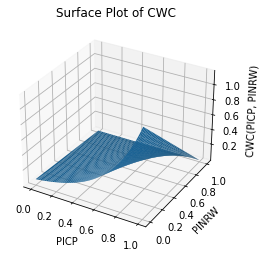

Maximum value of Z: 1.1583539630298554
Corresponding PICP and PINRW values: 0.999 0.0


In [9]:
from mpl_toolkits.mplot3d import Axes3D

etta = 3
mu = 0.95

x = np.arange(0, 1, 0.001)
y = np.arange(0, 1, 0.001)
X, Y = np.meshgrid(x, y)
Z = (1-Y) * (np.exp(etta * (X - mu)))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z)

ax.set_xlabel('PICP')
ax.set_ylabel('PINRW')
ax.set_zlabel('CWC(PICP, PINRW)')
ax.set_title('Surface Plot of CWC')

plt.show()

max_value = np.max(Z)
max_index = np.unravel_index(np.argmax(Z), Z.shape)
max_x = X[max_index]
max_y = Y[max_index]

print("Maximum value of Z:", max_value)
print("Corresponding PICP and PINRW values:", max_x, max_y)

In [10]:
def CWC(y_true, y_pred, etta = 3, mu = 0.95):

    return (1-PINRW(y_pred)) * (tf.exp(etta * (tf.subtract(PICP(y_true, y_pred), mu))))


In [11]:
df.tail()

,<DATE>,<CLOSE>
5005,2023-03-23,2388.35
5006,2023-03-24,2391.53
5007,2023-03-27,2440.68
5008,2023-03-28,2442.19
5009,2023-03-29,2444.90


In [12]:
# Split the data into training and test sets
train_size = int(len(df) * 0.8)
train = df[:train_size]
test = df[train_size:]

In [13]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train['<CLOSE>'].values.reshape(-1, 1))
test_scaled = scaler.transform(test['<CLOSE>'].values.reshape(-1, 1))
#train_scaled = train['<CLOSE>'].values.reshape(-1, 1)
#test_scaled = test['<CLOSE>'].values.reshape(-1, 1)

In [14]:
X_test = test_scaled[:-1]
y_test = test_scaled[1:]

In [15]:
X_train = train_scaled[:-1]
y_train = train_scaled[1:]

In [16]:
X_train.shape

(4007, 1)

In [17]:
y_train.shape

(4007, 1)

In [18]:
X_test.shape

(1001, 1)

In [19]:
y_test.shape

(1001, 1)

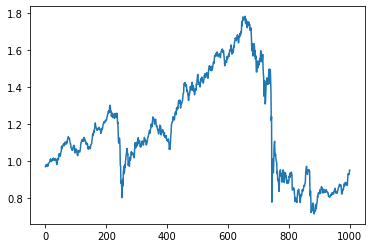

In [20]:
plt.plot(X_test)

In [21]:
# Define the model
model = Sequential([
    Dense(units=3),
    Dense(units=3),
    Dense(units=2)
])

# Build the model
input_shape = X_train.shape[1:]
model.build((None, *input_shape))

def get_shape(model):
    weights_layer = model.get_weights()
    shapes = []
    for weights in weights_layer:
        shapes.append(weights.shape)
    return shapes
def set_shape(weights,shapes):
    new_weights = []
    index=0
    for shape in shapes:
        if(len(shape)>1):
            n_nodes = np.prod(shape)+index
        else:
            n_nodes=shape[0]+index
        tmp = np.array(weights[index:n_nodes]).reshape(shape)
        new_weights.append(tmp)
        index=n_nodes
    return new_weights

def evaluate_nn(W, shape,X_train=X_train, Y_train=y_train):
    global model, max_value
    results = []
    for weights in W:
        model.set_weights(set_shape(weights,shape))
        predictions = model.predict(X_train)
        solution_fitness = 1-CWC(y_train, predictions).numpy() / max_value
        results.append(solution_fitness)
    return results


shape = get_shape(model)
x_max = 1.0 * np.ones(model.count_params())
x_min = -1.0 * x_max
bounds = (x_min, x_max)
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
optimizer = GlobalBestPSO(n_particles=30, dimensions=model.count_params(),
                          options=options, bounds=bounds)

cost, pos = optimizer.optimize(evaluate_nn, 1000, X_train=X_train, Y_train=y_train,shape=shape)
model.set_weights(set_shape(pos,shape))

predictions = model.predict(X_test)
solution_fitness = 1-CWC(y_test, predictions).numpy() / max_value


2023-07-29 15:14:31.460864: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib64:/usr/local/lib
2023-07-29 15:14:31.461204: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib64:/usr/local/lib
2023-07-29 15:14:31.461526: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib64:/usr/local/lib
2023-07-29 15:14:31.461788: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'lib

126/126 [==============================] - 0s 592us/step


pyswarms.single.global_best:   0%|                      |1/1000, best_cost=0.851

126/126 [==============================] - 0s 610us/step


pyswarms.single.global_best:   0%|                      |2/1000, best_cost=0.546

126/126 [==============================] - 0s 596us/step


pyswarms.single.global_best:   0%|                      |3/1000, best_cost=0.546

126/126 [==============================] - 0s 633us/step


pyswarms.single.global_best:   0%|                      |4/1000, best_cost=0.546

126/126 [==============================] - 0s 656us/step


pyswarms.single.global_best:   0%|                      |5/1000, best_cost=0.546

126/126 [==============================] - 0s 635us/step


pyswarms.single.global_best:   1%|▏                     |6/1000, best_cost=0.546

126/126 [==============================] - 0s 636us/step


pyswarms.single.global_best:   1%|▏                      |7/1000, best_cost=0.49

126/126 [==============================] - 0s 627us/step


pyswarms.single.global_best:   1%|▏                      |8/1000, best_cost=0.49

126/126 [==============================] - 0s 615us/step


pyswarms.single.global_best:   1%|▏                      |9/1000, best_cost=0.49

126/126 [==============================] - 0s 604us/step


pyswarms.single.global_best:   1%|▏                     |10/1000, best_cost=0.49

126/126 [==============================] - 0s 618us/step


pyswarms.single.global_best:   1%|▏                     |11/1000, best_cost=0.49

126/126 [==============================] - 0s 601us/step


pyswarms.single.global_best:   1%|▎                     |12/1000, best_cost=0.49

126/126 [==============================] - 0s 605us/step


pyswarms.single.global_best:   1%|▎                     |13/1000, best_cost=0.49

126/126 [==============================] - 0s 607us/step


pyswarms.single.global_best:   1%|▎                     |14/1000, best_cost=0.49

126/126 [==============================] - 0s 642us/step


pyswarms.single.global_best:   2%|▎                     |15/1000, best_cost=0.49

126/126 [==============================] - 0s 614us/step


pyswarms.single.global_best:   2%|▎                     |16/1000, best_cost=0.49

126/126 [==============================] - 0s 582us/step


pyswarms.single.global_best:   2%|▎                     |17/1000, best_cost=0.49

126/126 [==============================] - 0s 667us/step


pyswarms.single.global_best:   2%|▍                     |18/1000, best_cost=0.49

126/126 [==============================] - 0s 593us/step


pyswarms.single.global_best:   2%|▍                     |19/1000, best_cost=0.49

126/126 [==============================] - 0s 589us/step


pyswarms.single.global_best:   2%|▍                     |20/1000, best_cost=0.49

126/126 [==============================] - 0s 599us/step


pyswarms.single.global_best:   2%|▍                     |21/1000, best_cost=0.49

126/126 [==============================] - 0s 590us/step


pyswarms.single.global_best:   2%|▍                     |22/1000, best_cost=0.49

126/126 [==============================] - 0s 598us/step


pyswarms.single.global_best:   2%|▌                     |23/1000, best_cost=0.49

126/126 [==============================] - 0s 593us/step


pyswarms.single.global_best:   2%|▌                     |24/1000, best_cost=0.49

126/126 [==============================] - 0s 595us/step


pyswarms.single.global_best:   2%|▌                     |25/1000, best_cost=0.49

126/126 [==============================] - 0s 617us/step


pyswarms.single.global_best:   3%|▌                     |26/1000, best_cost=0.49

126/126 [==============================] - 0s 554us/step


pyswarms.single.global_best:   3%|▌                     |27/1000, best_cost=0.49

126/126 [==============================] - 0s 600us/step


pyswarms.single.global_best:   3%|▌                     |28/1000, best_cost=0.49

126/126 [==============================] - 0s 599us/step


pyswarms.single.global_best:   3%|▋                     |29/1000, best_cost=0.49

126/126 [==============================] - 0s 574us/step


pyswarms.single.global_best:   3%|▋                     |30/1000, best_cost=0.49

126/126 [==============================] - 0s 559us/step


pyswarms.single.global_best:   3%|▋                     |31/1000, best_cost=0.49

126/126 [==============================] - 0s 584us/step


pyswarms.single.global_best:   3%|▋                     |32/1000, best_cost=0.49

126/126 [==============================] - 0s 559us/step


pyswarms.single.global_best:   3%|▋                     |33/1000, best_cost=0.49

126/126 [==============================] - 0s 580us/step


pyswarms.single.global_best:   3%|▋                     |34/1000, best_cost=0.49

126/126 [==============================] - 0s 614us/step


pyswarms.single.global_best:   4%|▊                     |35/1000, best_cost=0.49

126/126 [==============================] - 0s 605us/step


pyswarms.single.global_best:   4%|▊                     |36/1000, best_cost=0.49

126/126 [==============================] - 0s 574us/step


pyswarms.single.global_best:   4%|▊                     |37/1000, best_cost=0.49

126/126 [==============================] - 0s 562us/step


pyswarms.single.global_best:   4%|▊                     |38/1000, best_cost=0.49

126/126 [==============================] - 0s 581us/step


pyswarms.single.global_best:   4%|▊                     |39/1000, best_cost=0.49

126/126 [==============================] - 0s 575us/step


pyswarms.single.global_best:   4%|▉                     |40/1000, best_cost=0.49

126/126 [==============================] - 0s 591us/step


pyswarms.single.global_best:   4%|▉                     |41/1000, best_cost=0.49

126/126 [==============================] - 0s 595us/step


pyswarms.single.global_best:   4%|▉                     |42/1000, best_cost=0.49

126/126 [==============================] - 0s 541us/step


pyswarms.single.global_best:   4%|▉                    |43/1000, best_cost=0.392

126/126 [==============================] - 0s 596us/step


pyswarms.single.global_best:   4%|▉                    |44/1000, best_cost=0.392

126/126 [==============================] - 0s 558us/step


pyswarms.single.global_best:   4%|▉                    |45/1000, best_cost=0.392

126/126 [==============================] - 0s 589us/step


pyswarms.single.global_best:   5%|▉                    |46/1000, best_cost=0.392

126/126 [==============================] - 0s 566us/step


pyswarms.single.global_best:   5%|▉                    |47/1000, best_cost=0.392

126/126 [==============================] - 0s 612us/step


pyswarms.single.global_best:   5%|█                    |48/1000, best_cost=0.392

126/126 [==============================] - 0s 581us/step


pyswarms.single.global_best:   5%|█                    |49/1000, best_cost=0.392

126/126 [==============================] - 0s 596us/step


pyswarms.single.global_best:   5%|█                    |50/1000, best_cost=0.392

126/126 [==============================] - 0s 618us/step


pyswarms.single.global_best:   5%|█                    |51/1000, best_cost=0.392

126/126 [==============================] - 0s 592us/step


pyswarms.single.global_best:   5%|█                    |52/1000, best_cost=0.392

126/126 [==============================] - 0s 572us/step


pyswarms.single.global_best:   5%|█                    |53/1000, best_cost=0.392

126/126 [==============================] - 0s 602us/step


pyswarms.single.global_best:   5%|█▏                   |54/1000, best_cost=0.392

126/126 [==============================] - 0s 575us/step


pyswarms.single.global_best:   6%|█▏                   |55/1000, best_cost=0.392

126/126 [==============================] - 0s 565us/step


pyswarms.single.global_best:   6%|█▏                   |56/1000, best_cost=0.392

126/126 [==============================] - 0s 614us/step


pyswarms.single.global_best:   6%|█▏                   |57/1000, best_cost=0.392

126/126 [==============================] - 0s 592us/step


pyswarms.single.global_best:   6%|█▏                   |58/1000, best_cost=0.392

126/126 [==============================] - 0s 599us/step


pyswarms.single.global_best:   6%|█▏                   |59/1000, best_cost=0.392

126/126 [==============================] - 0s 591us/step


pyswarms.single.global_best:   6%|█▎                   |60/1000, best_cost=0.392

126/126 [==============================] - 0s 562us/step


pyswarms.single.global_best:   6%|█▎                   |61/1000, best_cost=0.392

126/126 [==============================] - 0s 593us/step


pyswarms.single.global_best:   6%|█▎                   |62/1000, best_cost=0.392

126/126 [==============================] - 0s 596us/step


pyswarms.single.global_best:   6%|█▎                   |63/1000, best_cost=0.392

126/126 [==============================] - 0s 607us/step


pyswarms.single.global_best:   6%|█▎                   |64/1000, best_cost=0.392

126/126 [==============================] - 0s 601us/step


pyswarms.single.global_best:   6%|█▎                   |65/1000, best_cost=0.392

126/126 [==============================] - 0s 607us/step


pyswarms.single.global_best:   7%|█▍                   |66/1000, best_cost=0.392

126/126 [==============================] - 0s 596us/step


pyswarms.single.global_best:   7%|█▍                   |67/1000, best_cost=0.392

126/126 [==============================] - 0s 592us/step


pyswarms.single.global_best:   7%|█▍                   |68/1000, best_cost=0.392

126/126 [==============================] - 0s 594us/step


pyswarms.single.global_best:   7%|█▍                   |69/1000, best_cost=0.392

126/126 [==============================] - 0s 602us/step


pyswarms.single.global_best:   7%|█▍                   |70/1000, best_cost=0.392

126/126 [==============================] - 0s 557us/step


pyswarms.single.global_best:   7%|█▍                   |71/1000, best_cost=0.392

126/126 [==============================] - 0s 570us/step


pyswarms.single.global_best:   7%|█▌                   |72/1000, best_cost=0.392

126/126 [==============================] - 0s 539us/step


pyswarms.single.global_best:   7%|█▌                   |73/1000, best_cost=0.392

126/126 [==============================] - 0s 598us/step


pyswarms.single.global_best:   7%|█▌                   |74/1000, best_cost=0.392

126/126 [==============================] - 0s 590us/step


pyswarms.single.global_best:   8%|█▌                   |75/1000, best_cost=0.392

126/126 [==============================] - 0s 577us/step


pyswarms.single.global_best:   8%|█▌                   |76/1000, best_cost=0.392

126/126 [==============================] - 0s 580us/step


pyswarms.single.global_best:   8%|█▌                   |77/1000, best_cost=0.392

126/126 [==============================] - 0s 623us/step


pyswarms.single.global_best:   8%|█▋                   |78/1000, best_cost=0.392

126/126 [==============================] - 0s 591us/step


pyswarms.single.global_best:   8%|█▋                   |79/1000, best_cost=0.392

126/126 [==============================] - 0s 593us/step


pyswarms.single.global_best:   8%|█▋                   |80/1000, best_cost=0.392

126/126 [==============================] - 0s 560us/step


pyswarms.single.global_best:   8%|█▋                   |81/1000, best_cost=0.392

126/126 [==============================] - 0s 614us/step


pyswarms.single.global_best:   8%|█▋                   |82/1000, best_cost=0.392

126/126 [==============================] - 0s 578us/step


pyswarms.single.global_best:   8%|█▋                   |83/1000, best_cost=0.392

126/126 [==============================] - 0s 598us/step


pyswarms.single.global_best:   8%|█▊                   |84/1000, best_cost=0.392

126/126 [==============================] - 0s 601us/step


pyswarms.single.global_best:   8%|█▊                   |85/1000, best_cost=0.392

126/126 [==============================] - 0s 605us/step


pyswarms.single.global_best:   9%|█▊                   |86/1000, best_cost=0.392

126/126 [==============================] - 0s 584us/step


pyswarms.single.global_best:   9%|█▊                   |87/1000, best_cost=0.392

126/126 [==============================] - 0s 615us/step


pyswarms.single.global_best:   9%|█▊                   |88/1000, best_cost=0.392

126/126 [==============================] - 0s 561us/step


pyswarms.single.global_best:   9%|█▊                   |89/1000, best_cost=0.392

126/126 [==============================] - 0s 564us/step


pyswarms.single.global_best:   9%|█▉                   |90/1000, best_cost=0.392

126/126 [==============================] - 0s 567us/step


pyswarms.single.global_best:   9%|█▉                   |91/1000, best_cost=0.392

126/126 [==============================] - 0s 585us/step


pyswarms.single.global_best:   9%|█▉                   |92/1000, best_cost=0.392

126/126 [==============================] - 0s 604us/step


pyswarms.single.global_best:   9%|█▉                   |93/1000, best_cost=0.392

126/126 [==============================] - 0s 594us/step


pyswarms.single.global_best:   9%|█▉                   |94/1000, best_cost=0.392

126/126 [==============================] - 0s 583us/step


pyswarms.single.global_best:  10%|█▉                   |95/1000, best_cost=0.392

126/126 [==============================] - 0s 584us/step


pyswarms.single.global_best:  10%|██                   |96/1000, best_cost=0.392

126/126 [==============================] - 0s 602us/step


pyswarms.single.global_best:  10%|██                   |97/1000, best_cost=0.392

126/126 [==============================] - 0s 789us/step


pyswarms.single.global_best:  10%|██                   |98/1000, best_cost=0.392

126/126 [==============================] - 0s 552us/step


pyswarms.single.global_best:  10%|██                   |99/1000, best_cost=0.392

126/126 [==============================] - 0s 575us/step


pyswarms.single.global_best:  10%|██                  |100/1000, best_cost=0.392

126/126 [==============================] - 0s 585us/step


pyswarms.single.global_best:  10%|██                  |101/1000, best_cost=0.392

126/126 [==============================] - 0s 585us/step


pyswarms.single.global_best:  10%|██                  |102/1000, best_cost=0.392

126/126 [==============================] - 0s 604us/step


pyswarms.single.global_best:  10%|██                  |103/1000, best_cost=0.392

126/126 [==============================] - 0s 604us/step


pyswarms.single.global_best:  10%|██                  |104/1000, best_cost=0.392

126/126 [==============================] - 0s 628us/step


pyswarms.single.global_best:  10%|██                  |105/1000, best_cost=0.392

126/126 [==============================] - 0s 595us/step


pyswarms.single.global_best:  11%|██                  |106/1000, best_cost=0.392

126/126 [==============================] - 0s 596us/step


pyswarms.single.global_best:  11%|██▏                 |107/1000, best_cost=0.392

126/126 [==============================] - 0s 579us/step


pyswarms.single.global_best:  11%|██▏                 |108/1000, best_cost=0.392

126/126 [==============================] - 0s 585us/step


pyswarms.single.global_best:  11%|██▏                 |109/1000, best_cost=0.392

126/126 [==============================] - 0s 589us/step


pyswarms.single.global_best:  11%|██▏                 |110/1000, best_cost=0.392

126/126 [==============================] - 0s 589us/step


pyswarms.single.global_best:  11%|██▏                 |111/1000, best_cost=0.392

126/126 [==============================] - 0s 568us/step


pyswarms.single.global_best:  11%|██▏                 |112/1000, best_cost=0.392

126/126 [==============================] - 0s 604us/step


pyswarms.single.global_best:  11%|██▎                 |113/1000, best_cost=0.392

126/126 [==============================] - 0s 559us/step


pyswarms.single.global_best:  11%|██▎                 |114/1000, best_cost=0.392

126/126 [==============================] - 0s 630us/step


pyswarms.single.global_best:  12%|██▎                 |115/1000, best_cost=0.392

126/126 [==============================] - 0s 630us/step


pyswarms.single.global_best:  12%|██▎                 |116/1000, best_cost=0.392

126/126 [==============================] - 0s 632us/step


pyswarms.single.global_best:  12%|██▎                 |117/1000, best_cost=0.392

126/126 [==============================] - 0s 583us/step


pyswarms.single.global_best:  12%|██▎                 |118/1000, best_cost=0.392

126/126 [==============================] - 0s 581us/step


pyswarms.single.global_best:  12%|██▍                 |119/1000, best_cost=0.392

126/126 [==============================] - 0s 589us/step


pyswarms.single.global_best:  12%|██▍                 |120/1000, best_cost=0.392

126/126 [==============================] - 0s 593us/step


pyswarms.single.global_best:  12%|██▍                 |121/1000, best_cost=0.392

126/126 [==============================] - 0s 635us/step


pyswarms.single.global_best:  12%|██▍                 |122/1000, best_cost=0.392

126/126 [==============================] - 0s 588us/step


pyswarms.single.global_best:  12%|██▍                 |123/1000, best_cost=0.392

126/126 [==============================] - 0s 611us/step


pyswarms.single.global_best:  12%|██▍                 |124/1000, best_cost=0.392

126/126 [==============================] - 0s 600us/step


pyswarms.single.global_best:  12%|██▌                 |125/1000, best_cost=0.392

126/126 [==============================] - 0s 572us/step


pyswarms.single.global_best:  13%|██▌                 |126/1000, best_cost=0.392

126/126 [==============================] - 0s 596us/step


pyswarms.single.global_best:  13%|██▌                 |127/1000, best_cost=0.392

126/126 [==============================] - 0s 623us/step


pyswarms.single.global_best:  13%|██▌                 |128/1000, best_cost=0.392

126/126 [==============================] - 0s 615us/step


pyswarms.single.global_best:  13%|██▌                 |129/1000, best_cost=0.392

126/126 [==============================] - 0s 583us/step


pyswarms.single.global_best:  13%|██▌                 |130/1000, best_cost=0.392

126/126 [==============================] - 0s 579us/step


pyswarms.single.global_best:  13%|██▌                 |131/1000, best_cost=0.392

126/126 [==============================] - 0s 610us/step


pyswarms.single.global_best:  13%|██▋                 |132/1000, best_cost=0.392

126/126 [==============================] - 0s 635us/step


pyswarms.single.global_best:  13%|██▋                 |133/1000, best_cost=0.392

126/126 [==============================] - 0s 602us/step


pyswarms.single.global_best:  13%|██▋                 |134/1000, best_cost=0.392

126/126 [==============================] - 0s 606us/step


pyswarms.single.global_best:  14%|██▋                 |135/1000, best_cost=0.392

126/126 [==============================] - 0s 636us/step


pyswarms.single.global_best:  14%|██▋                 |136/1000, best_cost=0.392

126/126 [==============================] - 0s 563us/step


pyswarms.single.global_best:  14%|██▋                 |137/1000, best_cost=0.392

126/126 [==============================] - 0s 584us/step


pyswarms.single.global_best:  14%|██▊                 |138/1000, best_cost=0.392

126/126 [==============================] - 0s 592us/step


pyswarms.single.global_best:  14%|██▊                 |139/1000, best_cost=0.392

126/126 [==============================] - 0s 625us/step


pyswarms.single.global_best:  14%|██▊                 |140/1000, best_cost=0.392

126/126 [==============================] - 0s 641us/step


pyswarms.single.global_best:  14%|██▊                 |141/1000, best_cost=0.392

126/126 [==============================] - 0s 610us/step


pyswarms.single.global_best:  14%|██▊                 |142/1000, best_cost=0.387

126/126 [==============================] - 0s 558us/step


pyswarms.single.global_best:  14%|██▊                 |143/1000, best_cost=0.387

126/126 [==============================] - 0s 595us/step


pyswarms.single.global_best:  14%|██▉                 |144/1000, best_cost=0.387

126/126 [==============================] - 0s 586us/step


pyswarms.single.global_best:  14%|██▉                 |145/1000, best_cost=0.387

126/126 [==============================] - 0s 578us/step


pyswarms.single.global_best:  15%|██▉                 |146/1000, best_cost=0.387

126/126 [==============================] - 0s 618us/step


pyswarms.single.global_best:  15%|██▉                 |147/1000, best_cost=0.387

126/126 [==============================] - 0s 611us/step


pyswarms.single.global_best:  15%|██▉                 |148/1000, best_cost=0.387

126/126 [==============================] - 0s 567us/step


pyswarms.single.global_best:  15%|██▉                 |149/1000, best_cost=0.387

126/126 [==============================] - 0s 612us/step


pyswarms.single.global_best:  15%|███                 |150/1000, best_cost=0.387

126/126 [==============================] - 0s 592us/step


pyswarms.single.global_best:  15%|███                 |151/1000, best_cost=0.387

126/126 [==============================] - 0s 575us/step


pyswarms.single.global_best:  15%|███                 |152/1000, best_cost=0.387

126/126 [==============================] - 0s 594us/step


pyswarms.single.global_best:  15%|███                 |153/1000, best_cost=0.387

126/126 [==============================] - 0s 574us/step


pyswarms.single.global_best:  15%|███                 |154/1000, best_cost=0.387

126/126 [==============================] - 0s 559us/step


pyswarms.single.global_best:  16%|███                 |155/1000, best_cost=0.387

126/126 [==============================] - 0s 535us/step


pyswarms.single.global_best:  16%|███                 |156/1000, best_cost=0.387

126/126 [==============================] - 0s 582us/step


pyswarms.single.global_best:  16%|███▏                |157/1000, best_cost=0.387

126/126 [==============================] - 0s 603us/step


pyswarms.single.global_best:  16%|███▏                |158/1000, best_cost=0.387

126/126 [==============================] - 0s 616us/step


pyswarms.single.global_best:  16%|███▏                |159/1000, best_cost=0.387

126/126 [==============================] - 0s 624us/step


pyswarms.single.global_best:  16%|███▏                |160/1000, best_cost=0.387

126/126 [==============================] - 0s 618us/step


pyswarms.single.global_best:  16%|███▏                |161/1000, best_cost=0.387

126/126 [==============================] - 0s 595us/step


pyswarms.single.global_best:  16%|███▏                |162/1000, best_cost=0.387

126/126 [==============================] - 0s 557us/step


pyswarms.single.global_best:  16%|███▎                |163/1000, best_cost=0.387

126/126 [==============================] - 0s 606us/step


pyswarms.single.global_best:  16%|███▎                |164/1000, best_cost=0.387

126/126 [==============================] - 0s 605us/step


pyswarms.single.global_best:  16%|███▎                |165/1000, best_cost=0.387

126/126 [==============================] - 0s 611us/step


pyswarms.single.global_best:  17%|███▎                |166/1000, best_cost=0.387

126/126 [==============================] - 0s 593us/step


pyswarms.single.global_best:  17%|███▎                |167/1000, best_cost=0.387

126/126 [==============================] - 0s 570us/step


pyswarms.single.global_best:  17%|███▎                |168/1000, best_cost=0.387

126/126 [==============================] - 0s 608us/step


pyswarms.single.global_best:  17%|███▍                |169/1000, best_cost=0.387

126/126 [==============================] - 0s 593us/step


pyswarms.single.global_best:  17%|███▍                |170/1000, best_cost=0.387

126/126 [==============================] - 0s 597us/step


pyswarms.single.global_best:  17%|███▍                |171/1000, best_cost=0.387

126/126 [==============================] - 0s 604us/step


pyswarms.single.global_best:  17%|███▌                 |172/1000, best_cost=0.37

126/126 [==============================] - 0s 602us/step


pyswarms.single.global_best:  17%|███▍                |173/1000, best_cost=0.306

126/126 [==============================] - 0s 628us/step


pyswarms.single.global_best:  17%|███▍                |174/1000, best_cost=0.306

126/126 [==============================] - 0s 596us/step


pyswarms.single.global_best:  18%|███▌                |175/1000, best_cost=0.306

126/126 [==============================] - 0s 584us/step


pyswarms.single.global_best:  18%|███▌                |176/1000, best_cost=0.306

126/126 [==============================] - 0s 579us/step


pyswarms.single.global_best:  18%|███▌                |177/1000, best_cost=0.306

126/126 [==============================] - 0s 603us/step


pyswarms.single.global_best:  18%|███▌                |178/1000, best_cost=0.306

126/126 [==============================] - 0s 561us/step


pyswarms.single.global_best:  18%|███▌                |179/1000, best_cost=0.306

126/126 [==============================] - 0s 607us/step


pyswarms.single.global_best:  18%|███▌                |180/1000, best_cost=0.306

126/126 [==============================] - 0s 619us/step


pyswarms.single.global_best:  18%|███▌                |181/1000, best_cost=0.306

126/126 [==============================] - 0s 675us/step


pyswarms.single.global_best:  18%|███▋                |182/1000, best_cost=0.306

126/126 [==============================] - 0s 592us/step


pyswarms.single.global_best:  18%|███▋                |183/1000, best_cost=0.306

126/126 [==============================] - 0s 613us/step


pyswarms.single.global_best:  18%|███▋                |184/1000, best_cost=0.306

126/126 [==============================] - 0s 606us/step


pyswarms.single.global_best:  18%|███▋                |185/1000, best_cost=0.306

126/126 [==============================] - 0s 574us/step


pyswarms.single.global_best:  19%|███▋                |186/1000, best_cost=0.306

126/126 [==============================] - 0s 589us/step


pyswarms.single.global_best:  19%|███▋                |187/1000, best_cost=0.306

126/126 [==============================] - 0s 616us/step


pyswarms.single.global_best:  19%|███▊                |188/1000, best_cost=0.306

126/126 [==============================] - 0s 583us/step


pyswarms.single.global_best:  19%|███▊                |189/1000, best_cost=0.306

126/126 [==============================] - 0s 592us/step


pyswarms.single.global_best:  19%|███▊                |190/1000, best_cost=0.306

126/126 [==============================] - 0s 561us/step


pyswarms.single.global_best:  19%|███▊                |191/1000, best_cost=0.306

126/126 [==============================] - 0s 569us/step


pyswarms.single.global_best:  19%|███▊                |192/1000, best_cost=0.306

126/126 [==============================] - 0s 598us/step


pyswarms.single.global_best:  19%|███▊                |193/1000, best_cost=0.306

126/126 [==============================] - 0s 619us/step


pyswarms.single.global_best:  19%|███▉                |194/1000, best_cost=0.306

126/126 [==============================] - 0s 611us/step


pyswarms.single.global_best:  20%|███▉                |195/1000, best_cost=0.306

126/126 [==============================] - 0s 587us/step


pyswarms.single.global_best:  20%|███▉                |196/1000, best_cost=0.306

126/126 [==============================] - 0s 624us/step


pyswarms.single.global_best:  20%|███▉                |197/1000, best_cost=0.306

126/126 [==============================] - 0s 561us/step


pyswarms.single.global_best:  20%|███▉                |198/1000, best_cost=0.306

126/126 [==============================] - 0s 583us/step


pyswarms.single.global_best:  20%|███▉                |199/1000, best_cost=0.306

126/126 [==============================] - 0s 617us/step


pyswarms.single.global_best:  20%|████                |200/1000, best_cost=0.306

126/126 [==============================] - 0s 611us/step


pyswarms.single.global_best:  20%|████                |201/1000, best_cost=0.306

126/126 [==============================] - 0s 568us/step


pyswarms.single.global_best:  20%|████                |202/1000, best_cost=0.306

126/126 [==============================] - 0s 591us/step


pyswarms.single.global_best:  20%|████                |203/1000, best_cost=0.306

126/126 [==============================] - 0s 678us/step


pyswarms.single.global_best:  20%|████                |204/1000, best_cost=0.306

126/126 [==============================] - 0s 593us/step


pyswarms.single.global_best:  20%|████                |205/1000, best_cost=0.306

126/126 [==============================] - 0s 595us/step


pyswarms.single.global_best:  21%|████                |206/1000, best_cost=0.306

126/126 [==============================] - 0s 556us/step


pyswarms.single.global_best:  21%|████▏               |207/1000, best_cost=0.306

126/126 [==============================] - 0s 570us/step


pyswarms.single.global_best:  21%|████▏               |208/1000, best_cost=0.306

126/126 [==============================] - 0s 571us/step


pyswarms.single.global_best:  21%|████▏               |209/1000, best_cost=0.306

126/126 [==============================] - 0s 545us/step


pyswarms.single.global_best:  21%|████▏               |210/1000, best_cost=0.306

126/126 [==============================] - 0s 578us/step


pyswarms.single.global_best:  21%|████▏               |211/1000, best_cost=0.306

126/126 [==============================] - 0s 598us/step


pyswarms.single.global_best:  21%|████▏               |212/1000, best_cost=0.306

126/126 [==============================] - 0s 603us/step


pyswarms.single.global_best:  21%|████▎               |213/1000, best_cost=0.258

126/126 [==============================] - 0s 582us/step


pyswarms.single.global_best:  21%|████▎               |214/1000, best_cost=0.258

126/126 [==============================] - 0s 616us/step


pyswarms.single.global_best:  22%|████▎               |215/1000, best_cost=0.258

126/126 [==============================] - 0s 574us/step


pyswarms.single.global_best:  22%|████▎               |216/1000, best_cost=0.258

126/126 [==============================] - 0s 594us/step


pyswarms.single.global_best:  22%|████▎               |217/1000, best_cost=0.258

126/126 [==============================] - 0s 575us/step


pyswarms.single.global_best:  22%|████▎               |218/1000, best_cost=0.258

126/126 [==============================] - 0s 579us/step


pyswarms.single.global_best:  22%|████▍               |219/1000, best_cost=0.258

126/126 [==============================] - 0s 615us/step


pyswarms.single.global_best:  22%|████▍               |220/1000, best_cost=0.258

126/126 [==============================] - 0s 574us/step


pyswarms.single.global_best:  22%|████▍               |221/1000, best_cost=0.258

126/126 [==============================] - 0s 595us/step


pyswarms.single.global_best:  22%|████▍               |222/1000, best_cost=0.258

126/126 [==============================] - 0s 621us/step


pyswarms.single.global_best:  22%|████▍               |223/1000, best_cost=0.258

126/126 [==============================] - 0s 603us/step


pyswarms.single.global_best:  22%|████▍               |224/1000, best_cost=0.258

126/126 [==============================] - 0s 572us/step


pyswarms.single.global_best:  22%|████▌               |225/1000, best_cost=0.258

126/126 [==============================] - 0s 602us/step


pyswarms.single.global_best:  23%|████▌               |226/1000, best_cost=0.258

126/126 [==============================] - 0s 559us/step


pyswarms.single.global_best:  23%|████▌               |227/1000, best_cost=0.258

126/126 [==============================] - 0s 581us/step


pyswarms.single.global_best:  23%|████▌               |228/1000, best_cost=0.258

126/126 [==============================] - 0s 612us/step


pyswarms.single.global_best:  23%|████▌               |229/1000, best_cost=0.258

126/126 [==============================] - 0s 616us/step


pyswarms.single.global_best:  23%|████▌               |230/1000, best_cost=0.258

126/126 [==============================] - 0s 619us/step


pyswarms.single.global_best:  23%|████▌               |231/1000, best_cost=0.258

126/126 [==============================] - 0s 595us/step


pyswarms.single.global_best:  23%|████▋               |232/1000, best_cost=0.258

126/126 [==============================] - 0s 571us/step


pyswarms.single.global_best:  23%|████▋               |233/1000, best_cost=0.258

126/126 [==============================] - 0s 569us/step


pyswarms.single.global_best:  23%|████▋               |234/1000, best_cost=0.258

126/126 [==============================] - 0s 616us/step


pyswarms.single.global_best:  24%|████▋               |235/1000, best_cost=0.258

126/126 [==============================] - 0s 607us/step


pyswarms.single.global_best:  24%|████▋               |236/1000, best_cost=0.258

126/126 [==============================] - 0s 686us/step


pyswarms.single.global_best:  24%|████▋               |237/1000, best_cost=0.258

126/126 [==============================] - 0s 625us/step


pyswarms.single.global_best:  24%|████▊               |238/1000, best_cost=0.258

126/126 [==============================] - 0s 612us/step


pyswarms.single.global_best:  24%|████▊               |239/1000, best_cost=0.258

126/126 [==============================] - 0s 609us/step


pyswarms.single.global_best:  24%|████▊               |240/1000, best_cost=0.258

126/126 [==============================] - 0s 679us/step


pyswarms.single.global_best:  24%|████▊               |241/1000, best_cost=0.258

126/126 [==============================] - 0s 635us/step


pyswarms.single.global_best:  24%|████▊               |242/1000, best_cost=0.258

126/126 [==============================] - 0s 628us/step


pyswarms.single.global_best:  24%|████▊               |243/1000, best_cost=0.258

126/126 [==============================] - 0s 652us/step


pyswarms.single.global_best:  24%|████▉               |244/1000, best_cost=0.258

126/126 [==============================] - 0s 621us/step


pyswarms.single.global_best:  24%|████▉               |245/1000, best_cost=0.258

126/126 [==============================] - 0s 589us/step


pyswarms.single.global_best:  25%|████▉               |246/1000, best_cost=0.258

126/126 [==============================] - 0s 557us/step


pyswarms.single.global_best:  25%|████▉               |247/1000, best_cost=0.258

126/126 [==============================] - 0s 682us/step


pyswarms.single.global_best:  25%|████▉               |248/1000, best_cost=0.258

126/126 [==============================] - 0s 578us/step


pyswarms.single.global_best:  25%|████▉               |249/1000, best_cost=0.258

126/126 [==============================] - 0s 596us/step


pyswarms.single.global_best:  25%|█████               |250/1000, best_cost=0.258

126/126 [==============================] - 0s 602us/step


pyswarms.single.global_best:  25%|█████               |251/1000, best_cost=0.258

126/126 [==============================] - 0s 590us/step


pyswarms.single.global_best:  25%|█████               |252/1000, best_cost=0.258

126/126 [==============================] - 0s 561us/step


pyswarms.single.global_best:  25%|█████               |253/1000, best_cost=0.258

126/126 [==============================] - 0s 574us/step


pyswarms.single.global_best:  25%|█████               |254/1000, best_cost=0.258

126/126 [==============================] - 0s 611us/step


pyswarms.single.global_best:  26%|█████               |255/1000, best_cost=0.258

126/126 [==============================] - 0s 674us/step


pyswarms.single.global_best:  26%|█████               |256/1000, best_cost=0.258

126/126 [==============================] - 0s 688us/step


pyswarms.single.global_best:  26%|█████▏              |257/1000, best_cost=0.258

126/126 [==============================] - 0s 623us/step


pyswarms.single.global_best:  26%|█████▏              |258/1000, best_cost=0.258

126/126 [==============================] - 0s 604us/step


pyswarms.single.global_best:  26%|█████▏              |259/1000, best_cost=0.258

126/126 [==============================] - 0s 599us/step


pyswarms.single.global_best:  26%|█████▏              |260/1000, best_cost=0.258

126/126 [==============================] - 0s 598us/step


pyswarms.single.global_best:  26%|█████▏              |261/1000, best_cost=0.258

126/126 [==============================] - 0s 580us/step


pyswarms.single.global_best:  26%|█████▏              |262/1000, best_cost=0.258

126/126 [==============================] - 0s 602us/step


pyswarms.single.global_best:  26%|█████▎              |263/1000, best_cost=0.258

126/126 [==============================] - 0s 642us/step


pyswarms.single.global_best:  26%|█████▎              |264/1000, best_cost=0.258

126/126 [==============================] - 0s 586us/step


pyswarms.single.global_best:  26%|█████▎              |265/1000, best_cost=0.258

126/126 [==============================] - 0s 560us/step


pyswarms.single.global_best:  27%|█████▎              |266/1000, best_cost=0.258

126/126 [==============================] - 0s 674us/step


pyswarms.single.global_best:  27%|█████▎              |267/1000, best_cost=0.258

126/126 [==============================] - 0s 539us/step


pyswarms.single.global_best:  27%|█████▎              |268/1000, best_cost=0.258

126/126 [==============================] - 0s 607us/step


pyswarms.single.global_best:  27%|█████▍              |269/1000, best_cost=0.258

126/126 [==============================] - 0s 603us/step


pyswarms.single.global_best:  27%|█████▍              |270/1000, best_cost=0.258

126/126 [==============================] - 0s 644us/step


pyswarms.single.global_best:  27%|█████▍              |271/1000, best_cost=0.258

126/126 [==============================] - 0s 657us/step


pyswarms.single.global_best:  27%|█████▍              |272/1000, best_cost=0.258

126/126 [==============================] - 0s 654us/step


pyswarms.single.global_best:  27%|█████▍              |273/1000, best_cost=0.258

126/126 [==============================] - 0s 654us/step


pyswarms.single.global_best:  27%|█████▍              |274/1000, best_cost=0.258

126/126 [==============================] - 0s 564us/step


pyswarms.single.global_best:  28%|█████▌              |275/1000, best_cost=0.258

126/126 [==============================] - 0s 562us/step


pyswarms.single.global_best:  28%|█████▌              |276/1000, best_cost=0.258

126/126 [==============================] - 0s 724us/step


pyswarms.single.global_best:  28%|█████▌              |277/1000, best_cost=0.258

126/126 [==============================] - 0s 654us/step


pyswarms.single.global_best:  28%|█████▌              |278/1000, best_cost=0.258

126/126 [==============================] - 0s 662us/step


pyswarms.single.global_best:  28%|█████▌              |279/1000, best_cost=0.258

126/126 [==============================] - 0s 682us/step


pyswarms.single.global_best:  28%|█████▌              |280/1000, best_cost=0.258

126/126 [==============================] - 0s 623us/step


pyswarms.single.global_best:  28%|█████▌              |281/1000, best_cost=0.258

126/126 [==============================] - 0s 664us/step


pyswarms.single.global_best:  28%|█████▋              |282/1000, best_cost=0.258

126/126 [==============================] - 0s 580us/step


pyswarms.single.global_best:  28%|█████▋              |283/1000, best_cost=0.258

126/126 [==============================] - 0s 581us/step


pyswarms.single.global_best:  28%|█████▋              |284/1000, best_cost=0.258

126/126 [==============================] - 0s 590us/step


pyswarms.single.global_best:  28%|█████▋              |285/1000, best_cost=0.258

126/126 [==============================] - 0s 625us/step


pyswarms.single.global_best:  29%|█████▋              |286/1000, best_cost=0.258

126/126 [==============================] - 0s 793us/step


pyswarms.single.global_best:  29%|█████▋              |287/1000, best_cost=0.258

126/126 [==============================] - 0s 638us/step


pyswarms.single.global_best:  29%|█████▊              |288/1000, best_cost=0.258

126/126 [==============================] - 0s 601us/step


pyswarms.single.global_best:  29%|█████▊              |289/1000, best_cost=0.258

126/126 [==============================] - 0s 593us/step


pyswarms.single.global_best:  29%|█████▊              |290/1000, best_cost=0.258

126/126 [==============================] - 0s 626us/step


pyswarms.single.global_best:  29%|█████▊              |291/1000, best_cost=0.258

126/126 [==============================] - 0s 870us/step


pyswarms.single.global_best:  29%|█████▊              |292/1000, best_cost=0.258

126/126 [==============================] - 0s 656us/step


pyswarms.single.global_best:  29%|█████▊              |293/1000, best_cost=0.258

126/126 [==============================] - 0s 696us/step


pyswarms.single.global_best:  29%|█████▉              |294/1000, best_cost=0.258

126/126 [==============================] - 0s 746us/step


pyswarms.single.global_best:  30%|█████▉              |295/1000, best_cost=0.258

126/126 [==============================] - 0s 657us/step


pyswarms.single.global_best:  30%|█████▉              |296/1000, best_cost=0.258

126/126 [==============================] - 0s 755us/step


pyswarms.single.global_best:  30%|█████▉              |297/1000, best_cost=0.258

126/126 [==============================] - 0s 695us/step


pyswarms.single.global_best:  30%|█████▉              |298/1000, best_cost=0.258

126/126 [==============================] - 0s 653us/step


pyswarms.single.global_best:  30%|█████▉              |299/1000, best_cost=0.258

126/126 [==============================] - 0s 682us/step


pyswarms.single.global_best:  30%|██████              |300/1000, best_cost=0.258

126/126 [==============================] - 0s 611us/step


pyswarms.single.global_best:  30%|██████              |301/1000, best_cost=0.258

126/126 [==============================] - 0s 648us/step


pyswarms.single.global_best:  30%|██████              |302/1000, best_cost=0.258

126/126 [==============================] - 0s 673us/step


pyswarms.single.global_best:  30%|██████              |303/1000, best_cost=0.258

126/126 [==============================] - 0s 636us/step


pyswarms.single.global_best:  30%|██████              |304/1000, best_cost=0.258

126/126 [==============================] - 0s 760us/step


pyswarms.single.global_best:  30%|██████              |305/1000, best_cost=0.258

126/126 [==============================] - 0s 647us/step


pyswarms.single.global_best:  31%|██████              |306/1000, best_cost=0.258

126/126 [==============================] - 0s 662us/step


pyswarms.single.global_best:  31%|██████▏             |307/1000, best_cost=0.258

126/126 [==============================] - 0s 689us/step


pyswarms.single.global_best:  31%|██████▏             |308/1000, best_cost=0.258

126/126 [==============================] - 0s 696us/step


pyswarms.single.global_best:  31%|██████▏             |309/1000, best_cost=0.258

126/126 [==============================] - 0s 615us/step


pyswarms.single.global_best:  31%|██████▏             |310/1000, best_cost=0.258

126/126 [==============================] - 0s 642us/step


pyswarms.single.global_best:  31%|██████▏             |311/1000, best_cost=0.258

126/126 [==============================] - 0s 671us/step


pyswarms.single.global_best:  31%|██████▏             |312/1000, best_cost=0.258

126/126 [==============================] - 0s 654us/step


pyswarms.single.global_best:  31%|██████▎             |313/1000, best_cost=0.258

126/126 [==============================] - 0s 688us/step


pyswarms.single.global_best:  31%|██████▎             |314/1000, best_cost=0.258

126/126 [==============================] - 0s 617us/step


pyswarms.single.global_best:  32%|██████▎             |315/1000, best_cost=0.258

126/126 [==============================] - 0s 618us/step


pyswarms.single.global_best:  32%|██████▎             |316/1000, best_cost=0.258

126/126 [==============================] - 0s 755us/step


pyswarms.single.global_best:  32%|██████▎             |317/1000, best_cost=0.258

126/126 [==============================] - 0s 596us/step


pyswarms.single.global_best:  32%|██████▎             |318/1000, best_cost=0.258

126/126 [==============================] - 0s 607us/step


pyswarms.single.global_best:  32%|██████▍             |319/1000, best_cost=0.258

126/126 [==============================] - 0s 602us/step


pyswarms.single.global_best:  32%|██████▍             |320/1000, best_cost=0.258

126/126 [==============================] - 0s 817us/step


pyswarms.single.global_best:  32%|██████▍             |321/1000, best_cost=0.258

126/126 [==============================] - 0s 770us/step


pyswarms.single.global_best:  32%|██████▍             |322/1000, best_cost=0.258

126/126 [==============================] - 0s 650us/step


pyswarms.single.global_best:  32%|██████▍             |323/1000, best_cost=0.258

126/126 [==============================] - 0s 648us/step


pyswarms.single.global_best:  32%|██████▍             |324/1000, best_cost=0.258

126/126 [==============================] - 0s 623us/step


pyswarms.single.global_best:  32%|██████▌             |325/1000, best_cost=0.258

126/126 [==============================] - 0s 663us/step


pyswarms.single.global_best:  33%|██████▌             |326/1000, best_cost=0.258

126/126 [==============================] - 0s 729us/step


pyswarms.single.global_best:  33%|██████▌             |327/1000, best_cost=0.258

126/126 [==============================] - 0s 693us/step


pyswarms.single.global_best:  33%|██████▌             |328/1000, best_cost=0.258

126/126 [==============================] - 0s 573us/step


pyswarms.single.global_best:  33%|██████▌             |329/1000, best_cost=0.258

126/126 [==============================] - 0s 603us/step


pyswarms.single.global_best:  33%|██████▌             |330/1000, best_cost=0.258

126/126 [==============================] - 0s 623us/step


pyswarms.single.global_best:  33%|██████▌             |331/1000, best_cost=0.258

126/126 [==============================] - 0s 880us/step


pyswarms.single.global_best:  33%|██████▋             |332/1000, best_cost=0.258

126/126 [==============================] - 0s 557us/step


pyswarms.single.global_best:  33%|██████▋             |333/1000, best_cost=0.258

126/126 [==============================] - 0s 596us/step


pyswarms.single.global_best:  33%|██████▋             |334/1000, best_cost=0.258

126/126 [==============================] - 0s 610us/step


pyswarms.single.global_best:  34%|██████▋             |335/1000, best_cost=0.258

126/126 [==============================] - 0s 613us/step


pyswarms.single.global_best:  34%|██████▋             |336/1000, best_cost=0.258

126/126 [==============================] - 0s 632us/step


pyswarms.single.global_best:  34%|██████▋             |337/1000, best_cost=0.258

126/126 [==============================] - 0s 614us/step


pyswarms.single.global_best:  34%|██████▊             |338/1000, best_cost=0.258

126/126 [==============================] - 0s 570us/step


pyswarms.single.global_best:  34%|██████▊             |339/1000, best_cost=0.258

126/126 [==============================] - 0s 595us/step


pyswarms.single.global_best:  34%|██████▊             |340/1000, best_cost=0.258

126/126 [==============================] - 0s 651us/step


pyswarms.single.global_best:  34%|██████▊             |341/1000, best_cost=0.258

126/126 [==============================] - 0s 725us/step


pyswarms.single.global_best:  34%|██████▊             |342/1000, best_cost=0.258

126/126 [==============================] - 0s 569us/step


pyswarms.single.global_best:  34%|██████▊             |343/1000, best_cost=0.258

126/126 [==============================] - 0s 588us/step


pyswarms.single.global_best:  34%|██████▉             |344/1000, best_cost=0.258

126/126 [==============================] - 0s 619us/step


pyswarms.single.global_best:  34%|██████▉             |345/1000, best_cost=0.258

126/126 [==============================] - 0s 612us/step


pyswarms.single.global_best:  35%|██████▉             |346/1000, best_cost=0.258

126/126 [==============================] - 0s 610us/step


pyswarms.single.global_best:  35%|██████▉             |347/1000, best_cost=0.258

126/126 [==============================] - 0s 571us/step


pyswarms.single.global_best:  35%|██████▉             |348/1000, best_cost=0.258

126/126 [==============================] - 0s 608us/step


pyswarms.single.global_best:  35%|██████▉             |349/1000, best_cost=0.258

126/126 [==============================] - 0s 594us/step


pyswarms.single.global_best:  35%|███████             |350/1000, best_cost=0.258

126/126 [==============================] - 0s 599us/step


pyswarms.single.global_best:  35%|███████             |351/1000, best_cost=0.258

126/126 [==============================] - 0s 617us/step


pyswarms.single.global_best:  35%|███████             |352/1000, best_cost=0.258

126/126 [==============================] - 0s 605us/step


pyswarms.single.global_best:  35%|███████             |353/1000, best_cost=0.258

126/126 [==============================] - 0s 573us/step


pyswarms.single.global_best:  35%|███████             |354/1000, best_cost=0.258

126/126 [==============================] - 0s 621us/step


pyswarms.single.global_best:  36%|███████             |355/1000, best_cost=0.258

126/126 [==============================] - 0s 639us/step


pyswarms.single.global_best:  36%|███████             |356/1000, best_cost=0.258

126/126 [==============================] - 0s 560us/step


pyswarms.single.global_best:  36%|███████▏            |357/1000, best_cost=0.258

126/126 [==============================] - 0s 560us/step


pyswarms.single.global_best:  36%|███████▏            |358/1000, best_cost=0.258

126/126 [==============================] - 0s 613us/step


pyswarms.single.global_best:  36%|███████▏            |359/1000, best_cost=0.258

126/126 [==============================] - 0s 668us/step


pyswarms.single.global_best:  36%|███████▏            |360/1000, best_cost=0.258

126/126 [==============================] - 0s 664us/step


pyswarms.single.global_best:  36%|███████▏            |361/1000, best_cost=0.258

126/126 [==============================] - 0s 594us/step


pyswarms.single.global_best:  36%|███████▏            |362/1000, best_cost=0.258

126/126 [==============================] - 0s 577us/step


pyswarms.single.global_best:  36%|███████▎            |363/1000, best_cost=0.258

126/126 [==============================] - 0s 624us/step


pyswarms.single.global_best:  36%|███████▎            |364/1000, best_cost=0.258

126/126 [==============================] - 0s 650us/step


pyswarms.single.global_best:  36%|███████▎            |365/1000, best_cost=0.258

126/126 [==============================] - 0s 681us/step


pyswarms.single.global_best:  37%|███████▎            |366/1000, best_cost=0.258

126/126 [==============================] - 0s 639us/step


pyswarms.single.global_best:  37%|███████▎            |367/1000, best_cost=0.258

126/126 [==============================] - 0s 597us/step


pyswarms.single.global_best:  37%|███████▎            |368/1000, best_cost=0.258

126/126 [==============================] - 0s 688us/step


pyswarms.single.global_best:  37%|███████▍            |369/1000, best_cost=0.258

126/126 [==============================] - 0s 639us/step


pyswarms.single.global_best:  37%|███████▍            |370/1000, best_cost=0.258

126/126 [==============================] - 0s 634us/step


pyswarms.single.global_best:  37%|███████▍            |371/1000, best_cost=0.258

126/126 [==============================] - 0s 641us/step


pyswarms.single.global_best:  37%|███████▍            |372/1000, best_cost=0.258

126/126 [==============================] - 0s 670us/step


pyswarms.single.global_best:  37%|███████▍            |373/1000, best_cost=0.258

126/126 [==============================] - 0s 650us/step


pyswarms.single.global_best:  37%|███████▍            |374/1000, best_cost=0.258

126/126 [==============================] - 0s 577us/step


pyswarms.single.global_best:  38%|███████▌            |375/1000, best_cost=0.258

126/126 [==============================] - 0s 571us/step


pyswarms.single.global_best:  38%|███████▌            |376/1000, best_cost=0.258

126/126 [==============================] - 0s 584us/step


pyswarms.single.global_best:  38%|███████▌            |377/1000, best_cost=0.258

126/126 [==============================] - 0s 593us/step


pyswarms.single.global_best:  38%|███████▌            |378/1000, best_cost=0.258

126/126 [==============================] - 0s 581us/step


pyswarms.single.global_best:  38%|███████▌            |379/1000, best_cost=0.258

126/126 [==============================] - 0s 567us/step


pyswarms.single.global_best:  38%|███████▌            |380/1000, best_cost=0.258

126/126 [==============================] - 0s 588us/step


pyswarms.single.global_best:  38%|███████▌            |381/1000, best_cost=0.258

126/126 [==============================] - 0s 613us/step


pyswarms.single.global_best:  38%|███████▋            |382/1000, best_cost=0.258

126/126 [==============================] - 0s 579us/step


pyswarms.single.global_best:  38%|███████▋            |383/1000, best_cost=0.258

126/126 [==============================] - 0s 539us/step


pyswarms.single.global_best:  38%|███████▋            |384/1000, best_cost=0.258

126/126 [==============================] - 0s 588us/step


pyswarms.single.global_best:  38%|███████▋            |385/1000, best_cost=0.258

126/126 [==============================] - 0s 610us/step


pyswarms.single.global_best:  39%|███████▋            |386/1000, best_cost=0.258

126/126 [==============================] - 0s 583us/step


pyswarms.single.global_best:  39%|███████▋            |387/1000, best_cost=0.258

126/126 [==============================] - 0s 618us/step


pyswarms.single.global_best:  39%|███████▊            |388/1000, best_cost=0.258

126/126 [==============================] - 0s 606us/step


pyswarms.single.global_best:  39%|███████▊            |389/1000, best_cost=0.258

126/126 [==============================] - 0s 598us/step


pyswarms.single.global_best:  39%|███████▊            |390/1000, best_cost=0.258

126/126 [==============================] - 0s 569us/step


pyswarms.single.global_best:  39%|███████▊            |391/1000, best_cost=0.258

126/126 [==============================] - 0s 586us/step


pyswarms.single.global_best:  39%|███████▊            |392/1000, best_cost=0.258

126/126 [==============================] - 0s 570us/step


pyswarms.single.global_best:  39%|███████▊            |393/1000, best_cost=0.258

126/126 [==============================] - 0s 598us/step


pyswarms.single.global_best:  39%|███████▉            |394/1000, best_cost=0.258

126/126 [==============================] - 0s 613us/step


pyswarms.single.global_best:  40%|███████▉            |395/1000, best_cost=0.258

126/126 [==============================] - 0s 580us/step


pyswarms.single.global_best:  40%|███████▉            |396/1000, best_cost=0.258

126/126 [==============================] - 0s 580us/step


pyswarms.single.global_best:  40%|███████▉            |397/1000, best_cost=0.258

126/126 [==============================] - 0s 561us/step


pyswarms.single.global_best:  40%|███████▉            |398/1000, best_cost=0.258

126/126 [==============================] - 0s 608us/step


pyswarms.single.global_best:  40%|███████▉            |399/1000, best_cost=0.258

126/126 [==============================] - 0s 583us/step


pyswarms.single.global_best:  40%|████████            |400/1000, best_cost=0.258

126/126 [==============================] - 0s 569us/step


pyswarms.single.global_best:  40%|████████            |401/1000, best_cost=0.258

126/126 [==============================] - 0s 588us/step


pyswarms.single.global_best:  40%|████████            |402/1000, best_cost=0.258

126/126 [==============================] - 0s 550us/step


pyswarms.single.global_best:  40%|████████            |403/1000, best_cost=0.258

126/126 [==============================] - 0s 623us/step


pyswarms.single.global_best:  40%|████████            |404/1000, best_cost=0.258

126/126 [==============================] - 0s 655us/step


pyswarms.single.global_best:  40%|████████            |405/1000, best_cost=0.258

126/126 [==============================] - 0s 592us/step


pyswarms.single.global_best:  41%|████████            |406/1000, best_cost=0.258

126/126 [==============================] - 0s 634us/step


pyswarms.single.global_best:  41%|████████▏           |407/1000, best_cost=0.258

126/126 [==============================] - 0s 623us/step


pyswarms.single.global_best:  41%|████████▏           |408/1000, best_cost=0.258

126/126 [==============================] - 0s 617us/step


pyswarms.single.global_best:  41%|████████▏           |409/1000, best_cost=0.258

126/126 [==============================] - 0s 594us/step


pyswarms.single.global_best:  41%|████████▏           |410/1000, best_cost=0.258

126/126 [==============================] - 0s 593us/step


pyswarms.single.global_best:  41%|████████▏           |411/1000, best_cost=0.258

126/126 [==============================] - 0s 600us/step


pyswarms.single.global_best:  41%|████████▏           |412/1000, best_cost=0.258

126/126 [==============================] - 0s 599us/step


pyswarms.single.global_best:  41%|████████▎           |413/1000, best_cost=0.258

126/126 [==============================] - 0s 596us/step


pyswarms.single.global_best:  41%|████████▎           |414/1000, best_cost=0.258

126/126 [==============================] - 0s 588us/step


pyswarms.single.global_best:  42%|████████▎           |415/1000, best_cost=0.258

126/126 [==============================] - 0s 602us/step


pyswarms.single.global_best:  42%|████████▎           |416/1000, best_cost=0.258

126/126 [==============================] - 0s 613us/step


pyswarms.single.global_best:  42%|████████▎           |417/1000, best_cost=0.258

126/126 [==============================] - 0s 604us/step


pyswarms.single.global_best:  42%|████████▎           |418/1000, best_cost=0.258

126/126 [==============================] - 0s 585us/step


pyswarms.single.global_best:  42%|████████▍           |419/1000, best_cost=0.258

126/126 [==============================] - 0s 594us/step


pyswarms.single.global_best:  42%|████████▍           |420/1000, best_cost=0.258

126/126 [==============================] - 0s 604us/step


pyswarms.single.global_best:  42%|████████▍           |421/1000, best_cost=0.258

126/126 [==============================] - 0s 590us/step


pyswarms.single.global_best:  42%|████████▍           |422/1000, best_cost=0.258

126/126 [==============================] - 0s 582us/step


pyswarms.single.global_best:  42%|████████▍           |423/1000, best_cost=0.258

126/126 [==============================] - 0s 577us/step


pyswarms.single.global_best:  42%|████████▍           |424/1000, best_cost=0.258

126/126 [==============================] - 0s 561us/step


pyswarms.single.global_best:  42%|████████▌           |425/1000, best_cost=0.258

126/126 [==============================] - 0s 596us/step


pyswarms.single.global_best:  43%|████████▌           |426/1000, best_cost=0.258

126/126 [==============================] - 0s 605us/step


pyswarms.single.global_best:  43%|████████▌           |427/1000, best_cost=0.258

126/126 [==============================] - 0s 573us/step


pyswarms.single.global_best:  43%|████████▌           |428/1000, best_cost=0.258

126/126 [==============================] - 0s 558us/step


pyswarms.single.global_best:  43%|████████▌           |429/1000, best_cost=0.258

126/126 [==============================] - 0s 555us/step


pyswarms.single.global_best:  43%|████████▌           |430/1000, best_cost=0.258

126/126 [==============================] - 0s 619us/step


pyswarms.single.global_best:  43%|████████▌           |431/1000, best_cost=0.258

126/126 [==============================] - 0s 593us/step


pyswarms.single.global_best:  43%|████████▋           |432/1000, best_cost=0.258

126/126 [==============================] - 0s 549us/step


pyswarms.single.global_best:  43%|████████▋           |433/1000, best_cost=0.258

126/126 [==============================] - 0s 622us/step


pyswarms.single.global_best:  43%|████████▋           |434/1000, best_cost=0.258

126/126 [==============================] - 0s 583us/step


pyswarms.single.global_best:  44%|████████▋           |435/1000, best_cost=0.258

126/126 [==============================] - 0s 560us/step


pyswarms.single.global_best:  44%|████████▋           |436/1000, best_cost=0.258

126/126 [==============================] - 0s 557us/step


pyswarms.single.global_best:  44%|████████▋           |437/1000, best_cost=0.258

126/126 [==============================] - 0s 603us/step


pyswarms.single.global_best:  44%|████████▊           |438/1000, best_cost=0.258

126/126 [==============================] - 0s 570us/step


pyswarms.single.global_best:  44%|████████▊           |439/1000, best_cost=0.258

126/126 [==============================] - 0s 618us/step


pyswarms.single.global_best:  44%|████████▊           |440/1000, best_cost=0.258

126/126 [==============================] - 0s 576us/step


pyswarms.single.global_best:  44%|████████▊           |441/1000, best_cost=0.258

126/126 [==============================] - 0s 572us/step


pyswarms.single.global_best:  44%|████████▊           |442/1000, best_cost=0.258

126/126 [==============================] - 0s 611us/step


pyswarms.single.global_best:  44%|████████▊           |443/1000, best_cost=0.258

126/126 [==============================] - 0s 553us/step


pyswarms.single.global_best:  44%|████████▉           |444/1000, best_cost=0.258

126/126 [==============================] - 0s 580us/step


pyswarms.single.global_best:  44%|████████▉           |445/1000, best_cost=0.258

126/126 [==============================] - 0s 564us/step


pyswarms.single.global_best:  45%|████████▉           |446/1000, best_cost=0.258

126/126 [==============================] - 0s 597us/step


pyswarms.single.global_best:  45%|████████▉           |447/1000, best_cost=0.258

126/126 [==============================] - 0s 578us/step


pyswarms.single.global_best:  45%|████████▉           |448/1000, best_cost=0.258

126/126 [==============================] - 0s 599us/step


pyswarms.single.global_best:  45%|████████▉           |449/1000, best_cost=0.258

126/126 [==============================] - 0s 574us/step


pyswarms.single.global_best:  45%|█████████           |450/1000, best_cost=0.258

126/126 [==============================] - 0s 594us/step


pyswarms.single.global_best:  45%|█████████           |451/1000, best_cost=0.258

126/126 [==============================] - 0s 589us/step


pyswarms.single.global_best:  45%|█████████           |452/1000, best_cost=0.258

126/126 [==============================] - 0s 599us/step


pyswarms.single.global_best:  45%|█████████           |453/1000, best_cost=0.258

126/126 [==============================] - 0s 577us/step


pyswarms.single.global_best:  45%|█████████           |454/1000, best_cost=0.258

126/126 [==============================] - 0s 633us/step


pyswarms.single.global_best:  46%|█████████           |455/1000, best_cost=0.258

126/126 [==============================] - 0s 544us/step


pyswarms.single.global_best:  46%|█████████           |456/1000, best_cost=0.258

126/126 [==============================] - 0s 577us/step


pyswarms.single.global_best:  46%|█████████▏          |457/1000, best_cost=0.258

126/126 [==============================] - 0s 578us/step


pyswarms.single.global_best:  46%|█████████▏          |458/1000, best_cost=0.258

126/126 [==============================] - 0s 575us/step


pyswarms.single.global_best:  46%|█████████▏          |459/1000, best_cost=0.258

126/126 [==============================] - 0s 586us/step


pyswarms.single.global_best:  46%|█████████▏          |460/1000, best_cost=0.258

126/126 [==============================] - 0s 601us/step


pyswarms.single.global_best:  46%|█████████▏          |461/1000, best_cost=0.258

126/126 [==============================] - 0s 593us/step


pyswarms.single.global_best:  46%|█████████▏          |462/1000, best_cost=0.258

126/126 [==============================] - 0s 577us/step


pyswarms.single.global_best:  46%|█████████▎          |463/1000, best_cost=0.258

126/126 [==============================] - 0s 577us/step


pyswarms.single.global_best:  46%|█████████▎          |464/1000, best_cost=0.258

126/126 [==============================] - 0s 566us/step


pyswarms.single.global_best:  46%|█████████▎          |465/1000, best_cost=0.258

126/126 [==============================] - 0s 595us/step


pyswarms.single.global_best:  47%|█████████▎          |466/1000, best_cost=0.258

126/126 [==============================] - 0s 577us/step


pyswarms.single.global_best:  47%|█████████▎          |467/1000, best_cost=0.258

126/126 [==============================] - 0s 611us/step


pyswarms.single.global_best:  47%|█████████▎          |468/1000, best_cost=0.258

126/126 [==============================] - 0s 568us/step


pyswarms.single.global_best:  47%|█████████▍          |469/1000, best_cost=0.258

126/126 [==============================] - 0s 599us/step


pyswarms.single.global_best:  47%|█████████▍          |470/1000, best_cost=0.258

126/126 [==============================] - 0s 598us/step


pyswarms.single.global_best:  47%|█████████▍          |471/1000, best_cost=0.258

126/126 [==============================] - 0s 616us/step


pyswarms.single.global_best:  47%|█████████▍          |472/1000, best_cost=0.258

126/126 [==============================] - 0s 602us/step


pyswarms.single.global_best:  47%|█████████▍          |473/1000, best_cost=0.258

126/126 [==============================] - 0s 590us/step


pyswarms.single.global_best:  47%|█████████▍          |474/1000, best_cost=0.258

126/126 [==============================] - 0s 615us/step


pyswarms.single.global_best:  48%|█████████▌          |475/1000, best_cost=0.258

126/126 [==============================] - 0s 598us/step


pyswarms.single.global_best:  48%|█████████▌          |476/1000, best_cost=0.258

126/126 [==============================] - 0s 581us/step


pyswarms.single.global_best:  48%|█████████▌          |477/1000, best_cost=0.258

126/126 [==============================] - 0s 603us/step


pyswarms.single.global_best:  48%|█████████▌          |478/1000, best_cost=0.258

126/126 [==============================] - 0s 590us/step


pyswarms.single.global_best:  48%|█████████▌          |479/1000, best_cost=0.258

126/126 [==============================] - 0s 585us/step


pyswarms.single.global_best:  48%|█████████▌          |480/1000, best_cost=0.258

126/126 [==============================] - 0s 589us/step


pyswarms.single.global_best:  48%|█████████▌          |481/1000, best_cost=0.258

126/126 [==============================] - 0s 604us/step


pyswarms.single.global_best:  48%|█████████▋          |482/1000, best_cost=0.258

126/126 [==============================] - 0s 686us/step


pyswarms.single.global_best:  48%|█████████▋          |483/1000, best_cost=0.258

126/126 [==============================] - 0s 593us/step


pyswarms.single.global_best:  48%|█████████▋          |484/1000, best_cost=0.258

126/126 [==============================] - 0s 590us/step


pyswarms.single.global_best:  48%|█████████▋          |485/1000, best_cost=0.258

126/126 [==============================] - 0s 608us/step


pyswarms.single.global_best:  49%|█████████▋          |486/1000, best_cost=0.258

126/126 [==============================] - 0s 598us/step


pyswarms.single.global_best:  49%|█████████▋          |487/1000, best_cost=0.258

126/126 [==============================] - 0s 594us/step


pyswarms.single.global_best:  49%|█████████▊          |488/1000, best_cost=0.258

126/126 [==============================] - 0s 572us/step


pyswarms.single.global_best:  49%|█████████▊          |489/1000, best_cost=0.258

126/126 [==============================] - 0s 589us/step


pyswarms.single.global_best:  49%|█████████▊          |490/1000, best_cost=0.258

126/126 [==============================] - 0s 596us/step


pyswarms.single.global_best:  49%|█████████▊          |491/1000, best_cost=0.258

126/126 [==============================] - 0s 595us/step


pyswarms.single.global_best:  49%|█████████▊          |492/1000, best_cost=0.258

126/126 [==============================] - 0s 638us/step


pyswarms.single.global_best:  49%|█████████▊          |493/1000, best_cost=0.258

126/126 [==============================] - 0s 561us/step


pyswarms.single.global_best:  49%|█████████▉          |494/1000, best_cost=0.258

126/126 [==============================] - 0s 594us/step


pyswarms.single.global_best:  50%|█████████▉          |495/1000, best_cost=0.258

126/126 [==============================] - 0s 612us/step


pyswarms.single.global_best:  50%|█████████▉          |496/1000, best_cost=0.258

126/126 [==============================] - 0s 563us/step


pyswarms.single.global_best:  50%|█████████▉          |497/1000, best_cost=0.258

126/126 [==============================] - 0s 549us/step


pyswarms.single.global_best:  50%|█████████▉          |498/1000, best_cost=0.258

126/126 [==============================] - 0s 601us/step


pyswarms.single.global_best:  50%|█████████▉          |499/1000, best_cost=0.258

126/126 [==============================] - 0s 605us/step


pyswarms.single.global_best:  50%|██████████          |500/1000, best_cost=0.258

126/126 [==============================] - 0s 609us/step


pyswarms.single.global_best:  50%|██████████          |501/1000, best_cost=0.258

126/126 [==============================] - 0s 560us/step


pyswarms.single.global_best:  50%|██████████          |502/1000, best_cost=0.258

126/126 [==============================] - 0s 604us/step


pyswarms.single.global_best:  50%|██████████          |503/1000, best_cost=0.258

126/126 [==============================] - 0s 575us/step


pyswarms.single.global_best:  50%|██████████          |504/1000, best_cost=0.258

126/126 [==============================] - 0s 614us/step


pyswarms.single.global_best:  50%|██████████          |505/1000, best_cost=0.258

126/126 [==============================] - 0s 621us/step


pyswarms.single.global_best:  51%|██████████          |506/1000, best_cost=0.258

126/126 [==============================] - 0s 592us/step


pyswarms.single.global_best:  51%|██████████▏         |507/1000, best_cost=0.258

126/126 [==============================] - 0s 594us/step


pyswarms.single.global_best:  51%|██████████▏         |508/1000, best_cost=0.258

126/126 [==============================] - 0s 605us/step


pyswarms.single.global_best:  51%|██████████▏         |509/1000, best_cost=0.258

126/126 [==============================] - 0s 617us/step


pyswarms.single.global_best:  51%|██████████▏         |510/1000, best_cost=0.258

126/126 [==============================] - 0s 587us/step


pyswarms.single.global_best:  51%|██████████▏         |511/1000, best_cost=0.258

126/126 [==============================] - 0s 634us/step


pyswarms.single.global_best:  51%|██████████▏         |512/1000, best_cost=0.258

126/126 [==============================] - 0s 570us/step


pyswarms.single.global_best:  51%|██████████▎         |513/1000, best_cost=0.258

126/126 [==============================] - 0s 591us/step


pyswarms.single.global_best:  51%|██████████▎         |514/1000, best_cost=0.258

126/126 [==============================] - 0s 600us/step


pyswarms.single.global_best:  52%|██████████▎         |515/1000, best_cost=0.258

126/126 [==============================] - 0s 598us/step


pyswarms.single.global_best:  52%|██████████▎         |516/1000, best_cost=0.258

126/126 [==============================] - 0s 599us/step


pyswarms.single.global_best:  52%|██████████▎         |517/1000, best_cost=0.258

126/126 [==============================] - 0s 615us/step


pyswarms.single.global_best:  52%|██████████▎         |518/1000, best_cost=0.258

126/126 [==============================] - 0s 568us/step


pyswarms.single.global_best:  52%|██████████▍         |519/1000, best_cost=0.258

126/126 [==============================] - 0s 562us/step


pyswarms.single.global_best:  52%|██████████▍         |520/1000, best_cost=0.258

126/126 [==============================] - 0s 567us/step


pyswarms.single.global_best:  52%|██████████▍         |521/1000, best_cost=0.258

126/126 [==============================] - 0s 599us/step


pyswarms.single.global_best:  52%|██████████▍         |522/1000, best_cost=0.258

126/126 [==============================] - 0s 557us/step


pyswarms.single.global_best:  52%|██████████▍         |523/1000, best_cost=0.258

126/126 [==============================] - 0s 567us/step


pyswarms.single.global_best:  52%|██████████▍         |524/1000, best_cost=0.258

126/126 [==============================] - 0s 612us/step


pyswarms.single.global_best:  52%|██████████▌         |525/1000, best_cost=0.258

126/126 [==============================] - 0s 573us/step


pyswarms.single.global_best:  53%|██████████▌         |526/1000, best_cost=0.258

126/126 [==============================] - 0s 582us/step


pyswarms.single.global_best:  53%|██████████▌         |527/1000, best_cost=0.258

126/126 [==============================] - 0s 626us/step


pyswarms.single.global_best:  53%|██████████▌         |528/1000, best_cost=0.258

126/126 [==============================] - 0s 603us/step


pyswarms.single.global_best:  53%|██████████▌         |529/1000, best_cost=0.258

126/126 [==============================] - 0s 583us/step


pyswarms.single.global_best:  53%|██████████▌         |530/1000, best_cost=0.258

126/126 [==============================] - 0s 611us/step


pyswarms.single.global_best:  53%|██████████▌         |531/1000, best_cost=0.258

126/126 [==============================] - 0s 616us/step


pyswarms.single.global_best:  53%|██████████▋         |532/1000, best_cost=0.258

126/126 [==============================] - 0s 621us/step


pyswarms.single.global_best:  53%|██████████▋         |533/1000, best_cost=0.258

126/126 [==============================] - 0s 570us/step


pyswarms.single.global_best:  53%|██████████▋         |534/1000, best_cost=0.258

126/126 [==============================] - 0s 570us/step


pyswarms.single.global_best:  54%|██████████▋         |535/1000, best_cost=0.258

126/126 [==============================] - 0s 567us/step


pyswarms.single.global_best:  54%|██████████▋         |536/1000, best_cost=0.258

126/126 [==============================] - 0s 581us/step


pyswarms.single.global_best:  54%|██████████▋         |537/1000, best_cost=0.258

126/126 [==============================] - 0s 584us/step


pyswarms.single.global_best:  54%|██████████▊         |538/1000, best_cost=0.258

126/126 [==============================] - 0s 589us/step


pyswarms.single.global_best:  54%|██████████▊         |539/1000, best_cost=0.258

126/126 [==============================] - 0s 593us/step


pyswarms.single.global_best:  54%|██████████▊         |540/1000, best_cost=0.258

126/126 [==============================] - 0s 612us/step


pyswarms.single.global_best:  54%|██████████▊         |541/1000, best_cost=0.258

126/126 [==============================] - 0s 610us/step


pyswarms.single.global_best:  54%|██████████▊         |542/1000, best_cost=0.258

126/126 [==============================] - 0s 606us/step


pyswarms.single.global_best:  54%|██████████▊         |543/1000, best_cost=0.258

126/126 [==============================] - 0s 574us/step


pyswarms.single.global_best:  54%|██████████▉         |544/1000, best_cost=0.258

126/126 [==============================] - 0s 591us/step


pyswarms.single.global_best:  55%|██████████▉         |545/1000, best_cost=0.252

126/126 [==============================] - 0s 584us/step


pyswarms.single.global_best:  55%|██████████▉         |546/1000, best_cost=0.252

126/126 [==============================] - 0s 601us/step


pyswarms.single.global_best:  55%|██████████▉         |547/1000, best_cost=0.252

126/126 [==============================] - 0s 596us/step


pyswarms.single.global_best:  55%|██████████▉         |548/1000, best_cost=0.252

126/126 [==============================] - 0s 593us/step


pyswarms.single.global_best:  55%|██████████▉         |549/1000, best_cost=0.252

126/126 [==============================] - 0s 583us/step


pyswarms.single.global_best:  55%|███████████         |550/1000, best_cost=0.252

126/126 [==============================] - 0s 573us/step


pyswarms.single.global_best:  55%|███████████         |551/1000, best_cost=0.252

126/126 [==============================] - 0s 611us/step


pyswarms.single.global_best:  55%|███████████         |552/1000, best_cost=0.252

126/126 [==============================] - 0s 601us/step


pyswarms.single.global_best:  55%|███████████         |553/1000, best_cost=0.252

126/126 [==============================] - 0s 591us/step


pyswarms.single.global_best:  55%|███████████         |554/1000, best_cost=0.252

126/126 [==============================] - 0s 591us/step


pyswarms.single.global_best:  56%|███████████         |555/1000, best_cost=0.252

126/126 [==============================] - 0s 588us/step


pyswarms.single.global_best:  56%|███████████         |556/1000, best_cost=0.252

126/126 [==============================] - 0s 557us/step


pyswarms.single.global_best:  56%|███████████▏        |557/1000, best_cost=0.252

126/126 [==============================] - 0s 550us/step


pyswarms.single.global_best:  56%|███████████▏        |558/1000, best_cost=0.252

126/126 [==============================] - 0s 624us/step


pyswarms.single.global_best:  56%|███████████▏        |559/1000, best_cost=0.252

126/126 [==============================] - 0s 617us/step


pyswarms.single.global_best:  56%|███████████▏        |560/1000, best_cost=0.252

126/126 [==============================] - 0s 673us/step


pyswarms.single.global_best:  56%|███████████▏        |561/1000, best_cost=0.252

126/126 [==============================] - 0s 583us/step


pyswarms.single.global_best:  56%|███████████▏        |562/1000, best_cost=0.252

126/126 [==============================] - 0s 613us/step


pyswarms.single.global_best:  56%|███████████▎        |563/1000, best_cost=0.252

126/126 [==============================] - 0s 597us/step


pyswarms.single.global_best:  56%|███████████▎        |564/1000, best_cost=0.252

126/126 [==============================] - 0s 584us/step


pyswarms.single.global_best:  56%|███████████▎        |565/1000, best_cost=0.252

126/126 [==============================] - 0s 588us/step


pyswarms.single.global_best:  57%|███████████▎        |566/1000, best_cost=0.252

126/126 [==============================] - 0s 623us/step


pyswarms.single.global_best:  57%|███████████▎        |567/1000, best_cost=0.252

126/126 [==============================] - 0s 608us/step


pyswarms.single.global_best:  57%|███████████▎        |568/1000, best_cost=0.252

126/126 [==============================] - 0s 593us/step


pyswarms.single.global_best:  57%|███████████▍        |569/1000, best_cost=0.252

126/126 [==============================] - 0s 618us/step


pyswarms.single.global_best:  57%|███████████▍        |570/1000, best_cost=0.252

126/126 [==============================] - 0s 575us/step


pyswarms.single.global_best:  57%|███████████▍        |571/1000, best_cost=0.252

126/126 [==============================] - 0s 621us/step


pyswarms.single.global_best:  57%|███████████▍        |572/1000, best_cost=0.252

126/126 [==============================] - 0s 601us/step


pyswarms.single.global_best:  57%|███████████▍        |573/1000, best_cost=0.252

126/126 [==============================] - 0s 595us/step


pyswarms.single.global_best:  57%|███████████▍        |574/1000, best_cost=0.252

126/126 [==============================] - 0s 600us/step


pyswarms.single.global_best:  57%|███████████▌        |575/1000, best_cost=0.252

126/126 [==============================] - 0s 573us/step


pyswarms.single.global_best:  58%|███████████▌        |576/1000, best_cost=0.252

126/126 [==============================] - 0s 600us/step


pyswarms.single.global_best:  58%|███████████▌        |577/1000, best_cost=0.252

126/126 [==============================] - 0s 575us/step


pyswarms.single.global_best:  58%|███████████▌        |578/1000, best_cost=0.252

126/126 [==============================] - 0s 593us/step


pyswarms.single.global_best:  58%|███████████▌        |579/1000, best_cost=0.252

126/126 [==============================] - 0s 566us/step


pyswarms.single.global_best:  58%|███████████▌        |580/1000, best_cost=0.252

126/126 [==============================] - 0s 618us/step


pyswarms.single.global_best:  58%|███████████▌        |581/1000, best_cost=0.252

126/126 [==============================] - 0s 587us/step


pyswarms.single.global_best:  58%|███████████▋        |582/1000, best_cost=0.252

126/126 [==============================] - 0s 595us/step


pyswarms.single.global_best:  58%|███████████▋        |583/1000, best_cost=0.252

126/126 [==============================] - 0s 613us/step


pyswarms.single.global_best:  58%|███████████▋        |584/1000, best_cost=0.252

126/126 [==============================] - 0s 561us/step


pyswarms.single.global_best:  58%|███████████▋        |585/1000, best_cost=0.252

126/126 [==============================] - 0s 679us/step


pyswarms.single.global_best:  59%|███████████▋        |586/1000, best_cost=0.252

126/126 [==============================] - 0s 595us/step


pyswarms.single.global_best:  59%|███████████▋        |587/1000, best_cost=0.252

126/126 [==============================] - 0s 608us/step


pyswarms.single.global_best:  59%|███████████▊        |588/1000, best_cost=0.252

126/126 [==============================] - 0s 605us/step


pyswarms.single.global_best:  59%|███████████▊        |589/1000, best_cost=0.252

126/126 [==============================] - 0s 591us/step


pyswarms.single.global_best:  59%|███████████▊        |590/1000, best_cost=0.252

126/126 [==============================] - 0s 580us/step


pyswarms.single.global_best:  59%|███████████▊        |591/1000, best_cost=0.252

126/126 [==============================] - 0s 612us/step


pyswarms.single.global_best:  59%|███████████▊        |592/1000, best_cost=0.252

126/126 [==============================] - 0s 590us/step


pyswarms.single.global_best:  59%|███████████▊        |593/1000, best_cost=0.252

126/126 [==============================] - 0s 599us/step


pyswarms.single.global_best:  59%|███████████▉        |594/1000, best_cost=0.252

126/126 [==============================] - 0s 603us/step


pyswarms.single.global_best:  60%|███████████▉        |595/1000, best_cost=0.252

126/126 [==============================] - 0s 560us/step


pyswarms.single.global_best:  60%|███████████▉        |596/1000, best_cost=0.252

126/126 [==============================] - 0s 603us/step


pyswarms.single.global_best:  60%|███████████▉        |597/1000, best_cost=0.252

126/126 [==============================] - 0s 566us/step


pyswarms.single.global_best:  60%|███████████▉        |598/1000, best_cost=0.252

126/126 [==============================] - 0s 585us/step


pyswarms.single.global_best:  60%|███████████▉        |599/1000, best_cost=0.252

126/126 [==============================] - 0s 567us/step


pyswarms.single.global_best:  60%|████████████        |600/1000, best_cost=0.252

126/126 [==============================] - 0s 578us/step


pyswarms.single.global_best:  60%|████████████        |601/1000, best_cost=0.252

126/126 [==============================] - 0s 604us/step


pyswarms.single.global_best:  60%|████████████        |602/1000, best_cost=0.252

126/126 [==============================] - 0s 594us/step


pyswarms.single.global_best:  60%|████████████        |603/1000, best_cost=0.252

126/126 [==============================] - 0s 574us/step


pyswarms.single.global_best:  60%|████████████        |604/1000, best_cost=0.252

126/126 [==============================] - 0s 615us/step


pyswarms.single.global_best:  60%|████████████        |605/1000, best_cost=0.252

126/126 [==============================] - 0s 619us/step


pyswarms.single.global_best:  61%|████████████        |606/1000, best_cost=0.252

126/126 [==============================] - 0s 587us/step


pyswarms.single.global_best:  61%|████████████▏       |607/1000, best_cost=0.252

126/126 [==============================] - 0s 573us/step


pyswarms.single.global_best:  61%|████████████▏       |608/1000, best_cost=0.252

126/126 [==============================] - 0s 574us/step


pyswarms.single.global_best:  61%|████████████▏       |609/1000, best_cost=0.252

126/126 [==============================] - 0s 614us/step


pyswarms.single.global_best:  61%|████████████▏       |610/1000, best_cost=0.252

126/126 [==============================] - 0s 579us/step


pyswarms.single.global_best:  61%|████████████▏       |611/1000, best_cost=0.252

126/126 [==============================] - 0s 579us/step


pyswarms.single.global_best:  61%|████████████▏       |612/1000, best_cost=0.252

126/126 [==============================] - 0s 565us/step


pyswarms.single.global_best:  61%|████████████▎       |613/1000, best_cost=0.252

126/126 [==============================] - 0s 596us/step


pyswarms.single.global_best:  61%|████████████▎       |614/1000, best_cost=0.208

126/126 [==============================] - 0s 593us/step


pyswarms.single.global_best:  62%|████████████▎       |615/1000, best_cost=0.208

126/126 [==============================] - 0s 611us/step


pyswarms.single.global_best:  62%|████████████▎       |616/1000, best_cost=0.208

126/126 [==============================] - 0s 615us/step


pyswarms.single.global_best:  62%|████████████▎       |617/1000, best_cost=0.208

126/126 [==============================] - 0s 584us/step


pyswarms.single.global_best:  62%|████████████▎       |618/1000, best_cost=0.208

126/126 [==============================] - 0s 559us/step


pyswarms.single.global_best:  62%|████████████▍       |619/1000, best_cost=0.208

126/126 [==============================] - 0s 609us/step


pyswarms.single.global_best:  62%|████████████▍       |620/1000, best_cost=0.208

126/126 [==============================] - 0s 593us/step


pyswarms.single.global_best:  62%|████████████▍       |621/1000, best_cost=0.208

126/126 [==============================] - 0s 599us/step


pyswarms.single.global_best:  62%|████████████▍       |622/1000, best_cost=0.208

126/126 [==============================] - 0s 597us/step


pyswarms.single.global_best:  62%|████████████▍       |623/1000, best_cost=0.208

126/126 [==============================] - 0s 574us/step


pyswarms.single.global_best:  62%|████████████▍       |624/1000, best_cost=0.208

126/126 [==============================] - 0s 581us/step


pyswarms.single.global_best:  62%|████████████▌       |625/1000, best_cost=0.208

126/126 [==============================] - 0s 558us/step


pyswarms.single.global_best:  63%|████████████▌       |626/1000, best_cost=0.208

126/126 [==============================] - 0s 571us/step


pyswarms.single.global_best:  63%|█████████████▏       |627/1000, best_cost=0.14

126/126 [==============================] - 0s 584us/step


pyswarms.single.global_best:  63%|█████████████▏       |628/1000, best_cost=0.14

126/126 [==============================] - 0s 570us/step


pyswarms.single.global_best:  63%|█████████████▏       |629/1000, best_cost=0.14

126/126 [==============================] - 0s 588us/step


pyswarms.single.global_best:  63%|█████████████▏       |630/1000, best_cost=0.14

126/126 [==============================] - 0s 566us/step


pyswarms.single.global_best:  63%|█████████████▎       |631/1000, best_cost=0.14

126/126 [==============================] - 0s 614us/step


pyswarms.single.global_best:  63%|█████████████▎       |632/1000, best_cost=0.14

126/126 [==============================] - 0s 580us/step


pyswarms.single.global_best:  63%|█████████████▎       |633/1000, best_cost=0.14

126/126 [==============================] - 0s 612us/step


pyswarms.single.global_best:  63%|█████████████▎       |634/1000, best_cost=0.14

126/126 [==============================] - 0s 629us/step


pyswarms.single.global_best:  64%|█████████████▎       |635/1000, best_cost=0.14

126/126 [==============================] - 0s 612us/step


pyswarms.single.global_best:  64%|█████████████▎       |636/1000, best_cost=0.14

126/126 [==============================] - 0s 614us/step


pyswarms.single.global_best:  64%|█████████████▍       |637/1000, best_cost=0.14

126/126 [==============================] - 0s 607us/step


pyswarms.single.global_best:  64%|█████████████▍       |638/1000, best_cost=0.14

126/126 [==============================] - 0s 580us/step


pyswarms.single.global_best:  64%|█████████████▍       |639/1000, best_cost=0.14

126/126 [==============================] - 0s 613us/step


pyswarms.single.global_best:  64%|█████████████▍       |640/1000, best_cost=0.14

126/126 [==============================] - 0s 601us/step


pyswarms.single.global_best:  64%|█████████████▍       |641/1000, best_cost=0.14

126/126 [==============================] - 0s 604us/step


pyswarms.single.global_best:  64%|█████████████▍       |642/1000, best_cost=0.14

126/126 [==============================] - 0s 564us/step


pyswarms.single.global_best:  64%|█████████████▌       |643/1000, best_cost=0.14

126/126 [==============================] - 0s 578us/step


pyswarms.single.global_best:  64%|█████████████▌       |644/1000, best_cost=0.14

126/126 [==============================] - 0s 610us/step


pyswarms.single.global_best:  64%|█████████████▌       |645/1000, best_cost=0.14

126/126 [==============================] - 0s 581us/step


pyswarms.single.global_best:  65%|█████████████▌       |646/1000, best_cost=0.14

126/126 [==============================] - 0s 552us/step


pyswarms.single.global_best:  65%|█████████████▌       |647/1000, best_cost=0.14

126/126 [==============================] - 0s 583us/step


pyswarms.single.global_best:  65%|█████████████▌       |648/1000, best_cost=0.14

126/126 [==============================] - 0s 597us/step


pyswarms.single.global_best:  65%|█████████████▋       |649/1000, best_cost=0.14

126/126 [==============================] - 0s 584us/step


pyswarms.single.global_best:  65%|█████████████▋       |650/1000, best_cost=0.14

126/126 [==============================] - 0s 589us/step


pyswarms.single.global_best:  65%|█████████████▋       |651/1000, best_cost=0.14

126/126 [==============================] - 0s 613us/step


pyswarms.single.global_best:  65%|█████████████▋       |652/1000, best_cost=0.14

126/126 [==============================] - 0s 566us/step


pyswarms.single.global_best:  65%|█████████████▋       |653/1000, best_cost=0.14

126/126 [==============================] - 0s 599us/step


pyswarms.single.global_best:  65%|█████████████▋       |654/1000, best_cost=0.14

126/126 [==============================] - 0s 594us/step


pyswarms.single.global_best:  66%|█████████████▊       |655/1000, best_cost=0.14

126/126 [==============================] - 0s 559us/step


pyswarms.single.global_best:  66%|█████████████▊       |656/1000, best_cost=0.14

126/126 [==============================] - 0s 594us/step


pyswarms.single.global_best:  66%|█████████████▊       |657/1000, best_cost=0.14

126/126 [==============================] - 0s 612us/step


pyswarms.single.global_best:  66%|█████████████▊       |658/1000, best_cost=0.14

126/126 [==============================] - 0s 591us/step


pyswarms.single.global_best:  66%|█████████████▊       |659/1000, best_cost=0.14

126/126 [==============================] - 0s 594us/step


pyswarms.single.global_best:  66%|█████████████▊       |660/1000, best_cost=0.14

126/126 [==============================] - 0s 561us/step


pyswarms.single.global_best:  66%|█████████████▉       |661/1000, best_cost=0.14

126/126 [==============================] - 0s 555us/step


pyswarms.single.global_best:  66%|█████████████▉       |662/1000, best_cost=0.14

126/126 [==============================] - 0s 620us/step


pyswarms.single.global_best:  66%|█████████████▉       |663/1000, best_cost=0.14

126/126 [==============================] - 0s 594us/step


pyswarms.single.global_best:  66%|█████████████▉       |664/1000, best_cost=0.14

126/126 [==============================] - 0s 566us/step


pyswarms.single.global_best:  66%|█████████████▉       |665/1000, best_cost=0.14

126/126 [==============================] - 0s 639us/step


pyswarms.single.global_best:  67%|█████████████▉       |666/1000, best_cost=0.14

126/126 [==============================] - 0s 621us/step


pyswarms.single.global_best:  67%|██████████████       |667/1000, best_cost=0.14

126/126 [==============================] - 0s 633us/step


pyswarms.single.global_best:  67%|██████████████       |668/1000, best_cost=0.14

126/126 [==============================] - 0s 739us/step


pyswarms.single.global_best:  67%|██████████████       |669/1000, best_cost=0.14

126/126 [==============================] - 0s 638us/step


pyswarms.single.global_best:  67%|██████████████       |670/1000, best_cost=0.14

126/126 [==============================] - 0s 673us/step


pyswarms.single.global_best:  67%|██████████████       |671/1000, best_cost=0.14

126/126 [==============================] - 0s 587us/step


pyswarms.single.global_best:  67%|██████████████       |672/1000, best_cost=0.14

126/126 [==============================] - 0s 643us/step


pyswarms.single.global_best:  67%|██████████████▏      |673/1000, best_cost=0.14

126/126 [==============================] - 0s 616us/step


pyswarms.single.global_best:  67%|██████████████▏      |674/1000, best_cost=0.14

126/126 [==============================] - 0s 564us/step


pyswarms.single.global_best:  68%|██████████████▏      |675/1000, best_cost=0.14

126/126 [==============================] - 0s 633us/step


pyswarms.single.global_best:  68%|██████████████▏      |676/1000, best_cost=0.14

126/126 [==============================] - 0s 641us/step


pyswarms.single.global_best:  68%|██████████████▏      |677/1000, best_cost=0.14

126/126 [==============================] - 0s 637us/step


pyswarms.single.global_best:  68%|██████████████▏      |678/1000, best_cost=0.14

126/126 [==============================] - 0s 613us/step


pyswarms.single.global_best:  68%|██████████████▎      |679/1000, best_cost=0.14

126/126 [==============================] - 0s 589us/step


pyswarms.single.global_best:  68%|██████████████▎      |680/1000, best_cost=0.14

126/126 [==============================] - 0s 594us/step


pyswarms.single.global_best:  68%|██████████████▎      |681/1000, best_cost=0.14

126/126 [==============================] - 0s 617us/step


pyswarms.single.global_best:  68%|██████████████▎      |682/1000, best_cost=0.14

126/126 [==============================] - 0s 615us/step


pyswarms.single.global_best:  68%|██████████████▎      |683/1000, best_cost=0.14

126/126 [==============================] - 0s 631us/step


pyswarms.single.global_best:  68%|██████████████▎      |684/1000, best_cost=0.14

126/126 [==============================] - 0s 589us/step


pyswarms.single.global_best:  68%|██████████████▍      |685/1000, best_cost=0.14

126/126 [==============================] - 0s 581us/step


pyswarms.single.global_best:  69%|██████████████▍      |686/1000, best_cost=0.14

126/126 [==============================] - 0s 580us/step


pyswarms.single.global_best:  69%|██████████████▍      |687/1000, best_cost=0.14

126/126 [==============================] - 0s 583us/step


pyswarms.single.global_best:  69%|██████████████▍      |688/1000, best_cost=0.14

126/126 [==============================] - 0s 608us/step


pyswarms.single.global_best:  69%|██████████████▍      |689/1000, best_cost=0.14

126/126 [==============================] - 0s 580us/step


pyswarms.single.global_best:  69%|██████████████▍      |690/1000, best_cost=0.14

126/126 [==============================] - 0s 554us/step


pyswarms.single.global_best:  69%|██████████████▌      |691/1000, best_cost=0.14

126/126 [==============================] - 0s 572us/step


pyswarms.single.global_best:  69%|██████████████▌      |692/1000, best_cost=0.14

126/126 [==============================] - 0s 599us/step


pyswarms.single.global_best:  69%|██████████████▌      |693/1000, best_cost=0.14

126/126 [==============================] - 0s 571us/step


pyswarms.single.global_best:  69%|██████████████▌      |694/1000, best_cost=0.14

126/126 [==============================] - 0s 600us/step


pyswarms.single.global_best:  70%|██████████████▌      |695/1000, best_cost=0.14

126/126 [==============================] - 0s 639us/step


pyswarms.single.global_best:  70%|██████████████▌      |696/1000, best_cost=0.14

126/126 [==============================] - 0s 578us/step


pyswarms.single.global_best:  70%|██████████████▋      |697/1000, best_cost=0.14

126/126 [==============================] - 0s 585us/step


pyswarms.single.global_best:  70%|██████████████▋      |698/1000, best_cost=0.14

126/126 [==============================] - 0s 589us/step


pyswarms.single.global_best:  70%|██████████████▋      |699/1000, best_cost=0.14

126/126 [==============================] - 0s 611us/step


pyswarms.single.global_best:  70%|██████████████▋      |700/1000, best_cost=0.14

126/126 [==============================] - 0s 581us/step


pyswarms.single.global_best:  70%|██████████████▋      |701/1000, best_cost=0.14

126/126 [==============================] - 0s 594us/step


pyswarms.single.global_best:  70%|██████████████▋      |702/1000, best_cost=0.14

126/126 [==============================] - 0s 610us/step


pyswarms.single.global_best:  70%|██████████████▊      |703/1000, best_cost=0.14

126/126 [==============================] - 0s 584us/step


pyswarms.single.global_best:  70%|██████████████▊      |704/1000, best_cost=0.14

126/126 [==============================] - 0s 599us/step


pyswarms.single.global_best:  70%|██████████████▊      |705/1000, best_cost=0.14

126/126 [==============================] - 0s 602us/step


pyswarms.single.global_best:  71%|██████████████▊      |706/1000, best_cost=0.14

126/126 [==============================] - 0s 593us/step


pyswarms.single.global_best:  71%|██████████████▊      |707/1000, best_cost=0.14

126/126 [==============================] - 0s 621us/step


pyswarms.single.global_best:  71%|██████████████▊      |708/1000, best_cost=0.14

126/126 [==============================] - 0s 588us/step


pyswarms.single.global_best:  71%|██████████████▉      |709/1000, best_cost=0.14

126/126 [==============================] - 0s 568us/step


pyswarms.single.global_best:  71%|██████████████▉      |710/1000, best_cost=0.14

126/126 [==============================] - 0s 608us/step


pyswarms.single.global_best:  71%|██████████████▉      |711/1000, best_cost=0.14

126/126 [==============================] - 0s 627us/step


pyswarms.single.global_best:  71%|██████████████▉      |712/1000, best_cost=0.14

126/126 [==============================] - 0s 621us/step


pyswarms.single.global_best:  71%|██████████████▉      |713/1000, best_cost=0.14

126/126 [==============================] - 0s 573us/step


pyswarms.single.global_best:  71%|██████████████▉      |714/1000, best_cost=0.14

126/126 [==============================] - 0s 583us/step


pyswarms.single.global_best:  72%|███████████████      |715/1000, best_cost=0.14

126/126 [==============================] - 0s 593us/step


pyswarms.single.global_best:  72%|███████████████      |716/1000, best_cost=0.14

126/126 [==============================] - 0s 591us/step


pyswarms.single.global_best:  72%|███████████████      |717/1000, best_cost=0.14

126/126 [==============================] - 0s 562us/step


pyswarms.single.global_best:  72%|███████████████      |718/1000, best_cost=0.14

126/126 [==============================] - 0s 632us/step


pyswarms.single.global_best:  72%|███████████████      |719/1000, best_cost=0.14

126/126 [==============================] - 0s 593us/step


pyswarms.single.global_best:  72%|███████████████      |720/1000, best_cost=0.14

126/126 [==============================] - 0s 616us/step


pyswarms.single.global_best:  72%|███████████████▏     |721/1000, best_cost=0.14

126/126 [==============================] - 0s 692us/step


pyswarms.single.global_best:  72%|███████████████▏     |722/1000, best_cost=0.14

126/126 [==============================] - 0s 827us/step


pyswarms.single.global_best:  72%|███████████████▏     |723/1000, best_cost=0.14

126/126 [==============================] - 0s 705us/step


pyswarms.single.global_best:  72%|███████████████▏     |724/1000, best_cost=0.14

126/126 [==============================] - 0s 691us/step


pyswarms.single.global_best:  72%|███████████████▏     |725/1000, best_cost=0.14

126/126 [==============================] - 0s 692us/step


pyswarms.single.global_best:  73%|███████████████▏     |726/1000, best_cost=0.14

126/126 [==============================] - 0s 627us/step


pyswarms.single.global_best:  73%|███████████████▎     |727/1000, best_cost=0.14

126/126 [==============================] - 0s 671us/step


pyswarms.single.global_best:  73%|███████████████▎     |728/1000, best_cost=0.14

126/126 [==============================] - 0s 661us/step


pyswarms.single.global_best:  73%|███████████████▎     |729/1000, best_cost=0.14

126/126 [==============================] - 0s 624us/step


pyswarms.single.global_best:  73%|███████████████▎     |730/1000, best_cost=0.14

126/126 [==============================] - 0s 793us/step


pyswarms.single.global_best:  73%|███████████████▎     |731/1000, best_cost=0.14

126/126 [==============================] - 0s 688us/step


pyswarms.single.global_best:  73%|███████████████▎     |732/1000, best_cost=0.14

126/126 [==============================] - 0s 619us/step


pyswarms.single.global_best:  73%|███████████████▍     |733/1000, best_cost=0.14

126/126 [==============================] - 0s 599us/step


pyswarms.single.global_best:  73%|███████████████▍     |734/1000, best_cost=0.14

126/126 [==============================] - 0s 688us/step


pyswarms.single.global_best:  74%|███████████████▍     |735/1000, best_cost=0.14

126/126 [==============================] - 0s 640us/step


pyswarms.single.global_best:  74%|███████████████▍     |736/1000, best_cost=0.14

126/126 [==============================] - 0s 668us/step


pyswarms.single.global_best:  74%|███████████████▍     |737/1000, best_cost=0.14

126/126 [==============================] - 0s 703us/step


pyswarms.single.global_best:  74%|███████████████▍     |738/1000, best_cost=0.14

126/126 [==============================] - 0s 783us/step


pyswarms.single.global_best:  74%|███████████████▌     |739/1000, best_cost=0.14

126/126 [==============================] - 0s 652us/step


pyswarms.single.global_best:  74%|███████████████▌     |740/1000, best_cost=0.14

126/126 [==============================] - 0s 643us/step


pyswarms.single.global_best:  74%|███████████████▌     |741/1000, best_cost=0.14

126/126 [==============================] - 0s 653us/step


pyswarms.single.global_best:  74%|███████████████▌     |742/1000, best_cost=0.14

126/126 [==============================] - 0s 621us/step


pyswarms.single.global_best:  74%|███████████████▌     |743/1000, best_cost=0.14

126/126 [==============================] - 0s 622us/step


pyswarms.single.global_best:  74%|███████████████▌     |744/1000, best_cost=0.14

126/126 [==============================] - 0s 637us/step


pyswarms.single.global_best:  74%|███████████████▋     |745/1000, best_cost=0.14

126/126 [==============================] - 0s 641us/step


pyswarms.single.global_best:  75%|███████████████▋     |746/1000, best_cost=0.14

126/126 [==============================] - 0s 615us/step


pyswarms.single.global_best:  75%|███████████████▋     |747/1000, best_cost=0.14

126/126 [==============================] - 0s 635us/step


pyswarms.single.global_best:  75%|███████████████▋     |748/1000, best_cost=0.14

126/126 [==============================] - 0s 694us/step


pyswarms.single.global_best:  75%|███████████████▋     |749/1000, best_cost=0.14

126/126 [==============================] - 0s 715us/step


pyswarms.single.global_best:  75%|███████████████▊     |750/1000, best_cost=0.14

126/126 [==============================] - 0s 579us/step


pyswarms.single.global_best:  75%|███████████████▊     |751/1000, best_cost=0.14

126/126 [==============================] - 0s 578us/step


pyswarms.single.global_best:  75%|███████████████▊     |752/1000, best_cost=0.14

126/126 [==============================] - 0s 596us/step


pyswarms.single.global_best:  75%|███████████████▊     |753/1000, best_cost=0.14

126/126 [==============================] - 0s 590us/step


pyswarms.single.global_best:  75%|███████████████▊     |754/1000, best_cost=0.14

126/126 [==============================] - 0s 598us/step


pyswarms.single.global_best:  76%|███████████████▊     |755/1000, best_cost=0.14

126/126 [==============================] - 0s 608us/step


pyswarms.single.global_best:  76%|███████████████▉     |756/1000, best_cost=0.14

126/126 [==============================] - 0s 628us/step


pyswarms.single.global_best:  76%|███████████████▉     |757/1000, best_cost=0.14

126/126 [==============================] - 0s 617us/step


pyswarms.single.global_best:  76%|███████████████▉     |758/1000, best_cost=0.14

126/126 [==============================] - 0s 563us/step


pyswarms.single.global_best:  76%|███████████████▉     |759/1000, best_cost=0.14

126/126 [==============================] - 0s 550us/step


pyswarms.single.global_best:  76%|███████████████▉     |760/1000, best_cost=0.14

126/126 [==============================] - 0s 683us/step


pyswarms.single.global_best:  76%|███████████████▉     |761/1000, best_cost=0.14

126/126 [==============================] - 0s 595us/step


pyswarms.single.global_best:  76%|████████████████     |762/1000, best_cost=0.14

126/126 [==============================] - 0s 599us/step


pyswarms.single.global_best:  76%|████████████████     |763/1000, best_cost=0.14

126/126 [==============================] - 0s 595us/step


pyswarms.single.global_best:  76%|████████████████     |764/1000, best_cost=0.14

126/126 [==============================] - 0s 582us/step


pyswarms.single.global_best:  76%|████████████████     |765/1000, best_cost=0.14

126/126 [==============================] - 0s 630us/step


pyswarms.single.global_best:  77%|████████████████     |766/1000, best_cost=0.14

126/126 [==============================] - 0s 601us/step


pyswarms.single.global_best:  77%|████████████████     |767/1000, best_cost=0.14

126/126 [==============================] - 0s 603us/step


pyswarms.single.global_best:  77%|████████████████▏    |768/1000, best_cost=0.14

126/126 [==============================] - 0s 605us/step


pyswarms.single.global_best:  77%|████████████████▏    |769/1000, best_cost=0.14

126/126 [==============================] - 0s 605us/step


pyswarms.single.global_best:  77%|████████████████▏    |770/1000, best_cost=0.14

126/126 [==============================] - 0s 592us/step


pyswarms.single.global_best:  77%|████████████████▏    |771/1000, best_cost=0.14

126/126 [==============================] - 0s 605us/step


pyswarms.single.global_best:  77%|████████████████▏    |772/1000, best_cost=0.14

126/126 [==============================] - 0s 610us/step


pyswarms.single.global_best:  77%|████████████████▏    |773/1000, best_cost=0.14

126/126 [==============================] - 0s 635us/step


pyswarms.single.global_best:  77%|████████████████▎    |774/1000, best_cost=0.14

126/126 [==============================] - 0s 591us/step


pyswarms.single.global_best:  78%|████████████████▎    |775/1000, best_cost=0.14

126/126 [==============================] - 0s 565us/step


pyswarms.single.global_best:  78%|████████████████▎    |776/1000, best_cost=0.14

126/126 [==============================] - 0s 602us/step


pyswarms.single.global_best:  78%|████████████████▎    |777/1000, best_cost=0.14

126/126 [==============================] - 0s 587us/step


pyswarms.single.global_best:  78%|████████████████▎    |778/1000, best_cost=0.14

126/126 [==============================] - 0s 601us/step


pyswarms.single.global_best:  78%|████████████████▎    |779/1000, best_cost=0.14

126/126 [==============================] - 0s 568us/step


pyswarms.single.global_best:  78%|████████████████▍    |780/1000, best_cost=0.14

126/126 [==============================] - 0s 590us/step


pyswarms.single.global_best:  78%|████████████████▍    |781/1000, best_cost=0.14

126/126 [==============================] - 0s 590us/step


pyswarms.single.global_best:  78%|████████████████▍    |782/1000, best_cost=0.14

126/126 [==============================] - 0s 587us/step


pyswarms.single.global_best:  78%|████████████████▍    |783/1000, best_cost=0.14

126/126 [==============================] - 0s 594us/step


pyswarms.single.global_best:  78%|████████████████▍    |784/1000, best_cost=0.14

126/126 [==============================] - 0s 603us/step


pyswarms.single.global_best:  78%|████████████████▍    |785/1000, best_cost=0.14

126/126 [==============================] - 0s 576us/step


pyswarms.single.global_best:  79%|████████████████▌    |786/1000, best_cost=0.14

126/126 [==============================] - 0s 599us/step


pyswarms.single.global_best:  79%|████████████████▌    |787/1000, best_cost=0.14

126/126 [==============================] - 0s 604us/step


pyswarms.single.global_best:  79%|████████████████▌    |788/1000, best_cost=0.14

126/126 [==============================] - 0s 605us/step


pyswarms.single.global_best:  79%|████████████████▌    |789/1000, best_cost=0.14

126/126 [==============================] - 0s 600us/step


pyswarms.single.global_best:  79%|███████████████▊    |790/1000, best_cost=0.134

126/126 [==============================] - 0s 597us/step


pyswarms.single.global_best:  79%|███████████████▊    |791/1000, best_cost=0.134

126/126 [==============================] - 0s 605us/step


pyswarms.single.global_best:  79%|███████████████▊    |792/1000, best_cost=0.134

126/126 [==============================] - 0s 596us/step


pyswarms.single.global_best:  79%|███████████████▊    |793/1000, best_cost=0.134

126/126 [==============================] - 0s 640us/step


pyswarms.single.global_best:  79%|███████████████▉    |794/1000, best_cost=0.134

126/126 [==============================] - 0s 634us/step


pyswarms.single.global_best:  80%|███████████████▉    |795/1000, best_cost=0.134

126/126 [==============================] - 0s 635us/step


pyswarms.single.global_best:  80%|███████████████▉    |796/1000, best_cost=0.134

126/126 [==============================] - 0s 593us/step


pyswarms.single.global_best:  80%|███████████████▉    |797/1000, best_cost=0.134

126/126 [==============================] - 0s 568us/step


pyswarms.single.global_best:  80%|███████████████▉    |798/1000, best_cost=0.134

126/126 [==============================] - 0s 563us/step


pyswarms.single.global_best:  80%|███████████████▉    |799/1000, best_cost=0.134

126/126 [==============================] - 0s 581us/step


pyswarms.single.global_best:  80%|████████████████    |800/1000, best_cost=0.134

126/126 [==============================] - 0s 615us/step


pyswarms.single.global_best:  80%|████████████████    |801/1000, best_cost=0.134

126/126 [==============================] - 0s 594us/step


pyswarms.single.global_best:  80%|████████████████    |802/1000, best_cost=0.134

126/126 [==============================] - 0s 600us/step


pyswarms.single.global_best:  80%|████████████████    |803/1000, best_cost=0.134

126/126 [==============================] - 0s 567us/step


pyswarms.single.global_best:  80%|████████████████    |804/1000, best_cost=0.134

126/126 [==============================] - 0s 587us/step


pyswarms.single.global_best:  80%|████████████████    |805/1000, best_cost=0.134

126/126 [==============================] - 0s 584us/step


pyswarms.single.global_best:  81%|████████████████    |806/1000, best_cost=0.134

126/126 [==============================] - 0s 581us/step


pyswarms.single.global_best:  81%|████████████████▏   |807/1000, best_cost=0.134

126/126 [==============================] - 0s 594us/step


pyswarms.single.global_best:  81%|████████████████▏   |808/1000, best_cost=0.134

126/126 [==============================] - 0s 598us/step


pyswarms.single.global_best:  81%|████████████████▏   |809/1000, best_cost=0.134

126/126 [==============================] - 0s 628us/step


pyswarms.single.global_best:  81%|████████████████▏   |810/1000, best_cost=0.134

126/126 [==============================] - 0s 578us/step


pyswarms.single.global_best:  81%|████████████████▏   |811/1000, best_cost=0.134

126/126 [==============================] - 0s 596us/step


pyswarms.single.global_best:  81%|████████████████▏   |812/1000, best_cost=0.134

126/126 [==============================] - 0s 565us/step


pyswarms.single.global_best:  81%|████████████████▎   |813/1000, best_cost=0.134

126/126 [==============================] - 0s 603us/step


pyswarms.single.global_best:  81%|████████████████▎   |814/1000, best_cost=0.134

126/126 [==============================] - 0s 600us/step


pyswarms.single.global_best:  82%|████████████████▎   |815/1000, best_cost=0.134

126/126 [==============================] - 0s 582us/step


pyswarms.single.global_best:  82%|████████████████▎   |816/1000, best_cost=0.134

126/126 [==============================] - 0s 623us/step


pyswarms.single.global_best:  82%|████████████████▎   |817/1000, best_cost=0.134

126/126 [==============================] - 0s 595us/step


pyswarms.single.global_best:  82%|████████████████▎   |818/1000, best_cost=0.134

126/126 [==============================] - 0s 636us/step


pyswarms.single.global_best:  82%|████████████████▍   |819/1000, best_cost=0.134

126/126 [==============================] - 0s 610us/step


pyswarms.single.global_best:  82%|████████████████▍   |820/1000, best_cost=0.134

126/126 [==============================] - 0s 581us/step


pyswarms.single.global_best:  82%|████████████████▍   |821/1000, best_cost=0.134

126/126 [==============================] - 0s 608us/step


pyswarms.single.global_best:  82%|████████████████▍   |822/1000, best_cost=0.134

126/126 [==============================] - 0s 609us/step


pyswarms.single.global_best:  82%|████████████████▍   |823/1000, best_cost=0.134

126/126 [==============================] - 0s 571us/step


pyswarms.single.global_best:  82%|████████████████▍   |824/1000, best_cost=0.134

126/126 [==============================] - 0s 560us/step


pyswarms.single.global_best:  82%|████████████████▌   |825/1000, best_cost=0.134

126/126 [==============================] - 0s 558us/step


pyswarms.single.global_best:  83%|████████████████▌   |826/1000, best_cost=0.134

126/126 [==============================] - 0s 575us/step


pyswarms.single.global_best:  83%|████████████████▌   |827/1000, best_cost=0.134

126/126 [==============================] - 0s 560us/step


pyswarms.single.global_best:  83%|████████████████▌   |828/1000, best_cost=0.134

126/126 [==============================] - 0s 614us/step


pyswarms.single.global_best:  83%|████████████████▌   |829/1000, best_cost=0.134

126/126 [==============================] - 0s 611us/step


pyswarms.single.global_best:  83%|████████████████▌   |830/1000, best_cost=0.134

126/126 [==============================] - 0s 588us/step


pyswarms.single.global_best:  83%|████████████████▌   |831/1000, best_cost=0.134

126/126 [==============================] - 0s 604us/step


pyswarms.single.global_best:  83%|████████████████▋   |832/1000, best_cost=0.134

126/126 [==============================] - 0s 587us/step


pyswarms.single.global_best:  83%|████████████████▋   |833/1000, best_cost=0.134

126/126 [==============================] - 0s 587us/step


pyswarms.single.global_best:  83%|████████████████▋   |834/1000, best_cost=0.134

126/126 [==============================] - 0s 622us/step


pyswarms.single.global_best:  84%|████████████████▋   |835/1000, best_cost=0.134

126/126 [==============================] - 0s 610us/step


pyswarms.single.global_best:  84%|████████████████▋   |836/1000, best_cost=0.134

126/126 [==============================] - 0s 565us/step


pyswarms.single.global_best:  84%|████████████████▋   |837/1000, best_cost=0.134

126/126 [==============================] - 0s 574us/step


pyswarms.single.global_best:  84%|████████████████▊   |838/1000, best_cost=0.134

126/126 [==============================] - 0s 616us/step


pyswarms.single.global_best:  84%|████████████████▊   |839/1000, best_cost=0.134

126/126 [==============================] - 0s 603us/step


pyswarms.single.global_best:  84%|████████████████▊   |840/1000, best_cost=0.134

126/126 [==============================] - 0s 601us/step


pyswarms.single.global_best:  84%|████████████████▊   |841/1000, best_cost=0.134

126/126 [==============================] - 0s 571us/step


pyswarms.single.global_best:  84%|████████████████▊   |842/1000, best_cost=0.134

126/126 [==============================] - 0s 581us/step


pyswarms.single.global_best:  84%|████████████████▊   |843/1000, best_cost=0.134

126/126 [==============================] - 0s 609us/step


pyswarms.single.global_best:  84%|████████████████▉   |844/1000, best_cost=0.134

126/126 [==============================] - 0s 572us/step


pyswarms.single.global_best:  84%|████████████████▉   |845/1000, best_cost=0.134

126/126 [==============================] - 0s 633us/step


pyswarms.single.global_best:  85%|████████████████▉   |846/1000, best_cost=0.134

126/126 [==============================] - 0s 562us/step


pyswarms.single.global_best:  85%|████████████████▉   |847/1000, best_cost=0.134

126/126 [==============================] - 0s 596us/step


pyswarms.single.global_best:  85%|████████████████▉   |848/1000, best_cost=0.134

126/126 [==============================] - 0s 598us/step


pyswarms.single.global_best:  85%|████████████████▉   |849/1000, best_cost=0.134

126/126 [==============================] - 0s 562us/step


pyswarms.single.global_best:  85%|█████████████████   |850/1000, best_cost=0.134

126/126 [==============================] - 0s 614us/step


pyswarms.single.global_best:  85%|█████████████████   |851/1000, best_cost=0.134

126/126 [==============================] - 0s 623us/step


pyswarms.single.global_best:  85%|█████████████████   |852/1000, best_cost=0.113

126/126 [==============================] - 0s 620us/step


pyswarms.single.global_best:  85%|█████████████████   |853/1000, best_cost=0.113

126/126 [==============================] - 0s 672us/step


pyswarms.single.global_best:  85%|█████████████████   |854/1000, best_cost=0.113

126/126 [==============================] - 0s 867us/step


pyswarms.single.global_best:  86%|█████████████████   |855/1000, best_cost=0.113

126/126 [==============================] - 0s 631us/step


pyswarms.single.global_best:  86%|█████████████████   |856/1000, best_cost=0.113

126/126 [==============================] - 0s 577us/step


pyswarms.single.global_best:  86%|█████████████████▏  |857/1000, best_cost=0.113

126/126 [==============================] - 0s 668us/step


pyswarms.single.global_best:  86%|█████████████████▏  |858/1000, best_cost=0.113

126/126 [==============================] - 0s 704us/step


pyswarms.single.global_best:  86%|█████████████████▏  |859/1000, best_cost=0.113

126/126 [==============================] - 0s 651us/step


pyswarms.single.global_best:  86%|█████████████████▏  |860/1000, best_cost=0.113

126/126 [==============================] - 0s 602us/step


pyswarms.single.global_best:  86%|█████████████████▏  |861/1000, best_cost=0.113

126/126 [==============================] - 0s 591us/step


pyswarms.single.global_best:  86%|█████████████████▏  |862/1000, best_cost=0.113

126/126 [==============================] - 0s 563us/step


pyswarms.single.global_best:  86%|█████████████████▎  |863/1000, best_cost=0.113

126/126 [==============================] - 0s 610us/step


pyswarms.single.global_best:  86%|█████████████████▎  |864/1000, best_cost=0.113

126/126 [==============================] - 0s 584us/step


pyswarms.single.global_best:  86%|█████████████████▎  |865/1000, best_cost=0.113

126/126 [==============================] - 0s 630us/step


pyswarms.single.global_best:  87%|█████████████████▎  |866/1000, best_cost=0.113

126/126 [==============================] - 0s 561us/step


pyswarms.single.global_best:  87%|█████████████████▎  |867/1000, best_cost=0.113

126/126 [==============================] - 0s 620us/step


pyswarms.single.global_best:  87%|█████████████████▎  |868/1000, best_cost=0.113

126/126 [==============================] - 0s 579us/step


pyswarms.single.global_best:  87%|█████████████████▍  |869/1000, best_cost=0.113

126/126 [==============================] - 0s 628us/step


pyswarms.single.global_best:  87%|█████████████████▍  |870/1000, best_cost=0.113

126/126 [==============================] - 0s 610us/step


pyswarms.single.global_best:  87%|█████████████████▍  |871/1000, best_cost=0.113

126/126 [==============================] - 0s 594us/step


pyswarms.single.global_best:  87%|█████████████████▍  |872/1000, best_cost=0.113

126/126 [==============================] - 0s 572us/step


pyswarms.single.global_best:  87%|█████████████████▍  |873/1000, best_cost=0.113

126/126 [==============================] - 0s 653us/step


pyswarms.single.global_best:  87%|█████████████████▍  |874/1000, best_cost=0.113

126/126 [==============================] - 0s 623us/step


pyswarms.single.global_best:  88%|█████████████████▌  |875/1000, best_cost=0.113

126/126 [==============================] - 0s 605us/step


pyswarms.single.global_best:  88%|█████████████████▌  |876/1000, best_cost=0.113

126/126 [==============================] - 0s 601us/step


pyswarms.single.global_best:  88%|█████████████████▌  |877/1000, best_cost=0.113

126/126 [==============================] - 0s 676us/step


pyswarms.single.global_best:  88%|█████████████████▌  |878/1000, best_cost=0.113

126/126 [==============================] - 0s 606us/step


pyswarms.single.global_best:  88%|█████████████████▌  |879/1000, best_cost=0.113

126/126 [==============================] - 0s 594us/step


pyswarms.single.global_best:  88%|█████████████████▌  |880/1000, best_cost=0.113

126/126 [==============================] - 0s 565us/step


pyswarms.single.global_best:  88%|█████████████████▌  |881/1000, best_cost=0.113

126/126 [==============================] - 0s 612us/step


pyswarms.single.global_best:  88%|█████████████████▋  |882/1000, best_cost=0.113

126/126 [==============================] - 0s 612us/step


pyswarms.single.global_best:  88%|█████████████████▋  |883/1000, best_cost=0.113

126/126 [==============================] - 0s 616us/step


pyswarms.single.global_best:  88%|█████████████████▋  |884/1000, best_cost=0.113

126/126 [==============================] - 0s 592us/step


pyswarms.single.global_best:  88%|█████████████████▋  |885/1000, best_cost=0.113

126/126 [==============================] - 0s 630us/step


pyswarms.single.global_best:  89%|█████████████████▋  |886/1000, best_cost=0.113

126/126 [==============================] - 0s 623us/step


pyswarms.single.global_best:  89%|█████████████████▋  |887/1000, best_cost=0.113

126/126 [==============================] - 0s 583us/step


pyswarms.single.global_best:  89%|█████████████████▊  |888/1000, best_cost=0.113

126/126 [==============================] - 0s 598us/step


pyswarms.single.global_best:  89%|█████████████████▊  |889/1000, best_cost=0.113

126/126 [==============================] - 0s 607us/step


pyswarms.single.global_best:  89%|█████████████████▊  |890/1000, best_cost=0.113

126/126 [==============================] - 0s 608us/step


pyswarms.single.global_best:  89%|█████████████████▊  |891/1000, best_cost=0.113

126/126 [==============================] - 0s 608us/step


pyswarms.single.global_best:  89%|█████████████████▊  |892/1000, best_cost=0.113

126/126 [==============================] - 0s 614us/step


pyswarms.single.global_best:  89%|█████████████████▊  |893/1000, best_cost=0.113

126/126 [==============================] - 0s 606us/step


pyswarms.single.global_best:  89%|█████████████████▉  |894/1000, best_cost=0.113

126/126 [==============================] - 0s 620us/step


pyswarms.single.global_best:  90%|█████████████████▉  |895/1000, best_cost=0.113

126/126 [==============================] - 0s 602us/step


pyswarms.single.global_best:  90%|█████████████████▉  |896/1000, best_cost=0.113

126/126 [==============================] - 0s 589us/step


pyswarms.single.global_best:  90%|█████████████████▉  |897/1000, best_cost=0.113

126/126 [==============================] - 0s 619us/step


pyswarms.single.global_best:  90%|█████████████████▉  |898/1000, best_cost=0.113

126/126 [==============================] - 0s 604us/step


pyswarms.single.global_best:  90%|█████████████████▉  |899/1000, best_cost=0.113

126/126 [==============================] - 0s 571us/step


pyswarms.single.global_best:  90%|██████████████████  |900/1000, best_cost=0.113

126/126 [==============================] - 0s 599us/step


pyswarms.single.global_best:  90%|██████████████████  |901/1000, best_cost=0.113

126/126 [==============================] - 0s 622us/step


pyswarms.single.global_best:  90%|██████████████████  |902/1000, best_cost=0.113

126/126 [==============================] - 0s 593us/step


pyswarms.single.global_best:  90%|██████████████████  |903/1000, best_cost=0.113

126/126 [==============================] - 0s 632us/step


pyswarms.single.global_best:  90%|██████████████████  |904/1000, best_cost=0.113

126/126 [==============================] - 0s 601us/step


pyswarms.single.global_best:  90%|██████████████████  |905/1000, best_cost=0.113

126/126 [==============================] - 0s 598us/step


pyswarms.single.global_best:  91%|██████████████████  |906/1000, best_cost=0.113

126/126 [==============================] - 0s 602us/step


pyswarms.single.global_best:  91%|██████████████████▏ |907/1000, best_cost=0.113

126/126 [==============================] - 0s 591us/step


pyswarms.single.global_best:  91%|██████████████████▏ |908/1000, best_cost=0.113

126/126 [==============================] - 0s 597us/step


pyswarms.single.global_best:  91%|██████████████████▏ |909/1000, best_cost=0.113

126/126 [==============================] - 0s 594us/step


pyswarms.single.global_best:  91%|██████████████████▏ |910/1000, best_cost=0.113

126/126 [==============================] - 0s 581us/step


pyswarms.single.global_best:  91%|██████████████████▏ |911/1000, best_cost=0.113

126/126 [==============================] - 0s 587us/step


pyswarms.single.global_best:  91%|██████████████████▏ |912/1000, best_cost=0.113

126/126 [==============================] - 0s 567us/step


pyswarms.single.global_best:  91%|██████████████████▎ |913/1000, best_cost=0.113

126/126 [==============================] - 0s 614us/step


pyswarms.single.global_best:  91%|██████████████████▎ |914/1000, best_cost=0.113

126/126 [==============================] - 0s 615us/step


pyswarms.single.global_best:  92%|██████████████████▎ |915/1000, best_cost=0.113

126/126 [==============================] - 0s 599us/step


pyswarms.single.global_best:  92%|██████████████████▎ |916/1000, best_cost=0.113

126/126 [==============================] - 0s 613us/step


pyswarms.single.global_best:  92%|██████████████████▎ |917/1000, best_cost=0.113

126/126 [==============================] - 0s 601us/step


pyswarms.single.global_best:  92%|██████████████████▎ |918/1000, best_cost=0.113

126/126 [==============================] - 0s 798us/step


pyswarms.single.global_best:  92%|██████████████████▍ |919/1000, best_cost=0.113

126/126 [==============================] - 0s 627us/step


pyswarms.single.global_best:  92%|██████████████████▍ |920/1000, best_cost=0.113

126/126 [==============================] - 0s 580us/step


pyswarms.single.global_best:  92%|██████████████████▍ |921/1000, best_cost=0.113

126/126 [==============================] - 0s 674us/step


pyswarms.single.global_best:  92%|██████████████████▍ |922/1000, best_cost=0.113

126/126 [==============================] - 0s 583us/step


pyswarms.single.global_best:  92%|██████████████████▍ |923/1000, best_cost=0.113

126/126 [==============================] - 0s 581us/step


pyswarms.single.global_best:  92%|██████████████████▍ |924/1000, best_cost=0.113

126/126 [==============================] - 0s 619us/step


pyswarms.single.global_best:  92%|██████████████████▌ |925/1000, best_cost=0.113

126/126 [==============================] - 0s 619us/step


pyswarms.single.global_best:  93%|██████████████████▌ |926/1000, best_cost=0.113

126/126 [==============================] - 0s 606us/step


pyswarms.single.global_best:  93%|██████████████████▌ |927/1000, best_cost=0.113

126/126 [==============================] - 0s 645us/step


pyswarms.single.global_best:  93%|██████████████████▌ |928/1000, best_cost=0.113

126/126 [==============================] - 0s 620us/step


pyswarms.single.global_best:  93%|██████████████████▌ |929/1000, best_cost=0.113

126/126 [==============================] - 0s 584us/step


pyswarms.single.global_best:  93%|██████████████████▌ |930/1000, best_cost=0.113

126/126 [==============================] - 0s 587us/step


pyswarms.single.global_best:  93%|██████████████████▌ |931/1000, best_cost=0.113

126/126 [==============================] - 0s 603us/step


pyswarms.single.global_best:  93%|██████████████████▋ |932/1000, best_cost=0.113

126/126 [==============================] - 0s 597us/step


pyswarms.single.global_best:  93%|██████████████████▋ |933/1000, best_cost=0.113

126/126 [==============================] - 0s 605us/step


pyswarms.single.global_best:  93%|██████████████████▋ |934/1000, best_cost=0.113

126/126 [==============================] - 0s 583us/step


pyswarms.single.global_best:  94%|██████████████████▋ |935/1000, best_cost=0.113

126/126 [==============================] - 0s 678us/step


pyswarms.single.global_best:  94%|██████████████████▋ |936/1000, best_cost=0.113

126/126 [==============================] - 0s 620us/step


pyswarms.single.global_best:  94%|██████████████████▋ |937/1000, best_cost=0.113

126/126 [==============================] - 0s 611us/step


pyswarms.single.global_best:  94%|██████████████████▊ |938/1000, best_cost=0.113

126/126 [==============================] - 0s 592us/step


pyswarms.single.global_best:  94%|██████████████████▊ |939/1000, best_cost=0.113

126/126 [==============================] - 0s 618us/step


pyswarms.single.global_best:  94%|██████████████████▊ |940/1000, best_cost=0.113

126/126 [==============================] - 0s 608us/step


pyswarms.single.global_best:  94%|██████████████████▊ |941/1000, best_cost=0.113

126/126 [==============================] - 0s 632us/step


pyswarms.single.global_best:  94%|██████████████████▊ |942/1000, best_cost=0.113

126/126 [==============================] - 0s 546us/step


pyswarms.single.global_best:  94%|██████████████████▊ |943/1000, best_cost=0.113

126/126 [==============================] - 0s 625us/step


pyswarms.single.global_best:  94%|██████████████████▉ |944/1000, best_cost=0.113

126/126 [==============================] - 0s 632us/step


pyswarms.single.global_best:  94%|██████████████████▉ |945/1000, best_cost=0.113

126/126 [==============================] - 0s 621us/step


pyswarms.single.global_best:  95%|██████████████████▉ |946/1000, best_cost=0.113

126/126 [==============================] - 0s 655us/step


pyswarms.single.global_best:  95%|██████████████████▉ |947/1000, best_cost=0.113

126/126 [==============================] - 0s 564us/step


pyswarms.single.global_best:  95%|██████████████████▉ |948/1000, best_cost=0.113

126/126 [==============================] - 0s 637us/step


pyswarms.single.global_best:  95%|██████████████████▉ |949/1000, best_cost=0.113

126/126 [==============================] - 0s 642us/step


pyswarms.single.global_best:  95%|███████████████████ |950/1000, best_cost=0.113

126/126 [==============================] - 0s 576us/step


pyswarms.single.global_best:  95%|███████████████████ |951/1000, best_cost=0.113

126/126 [==============================] - 0s 618us/step


pyswarms.single.global_best:  95%|███████████████████ |952/1000, best_cost=0.113

126/126 [==============================] - 0s 611us/step


pyswarms.single.global_best:  95%|███████████████████ |953/1000, best_cost=0.113

126/126 [==============================] - 0s 552us/step


pyswarms.single.global_best:  95%|███████████████████ |954/1000, best_cost=0.113

126/126 [==============================] - 0s 611us/step


pyswarms.single.global_best:  96%|███████████████████ |955/1000, best_cost=0.113

126/126 [==============================] - 0s 723us/step


pyswarms.single.global_best:  96%|███████████████████ |956/1000, best_cost=0.113

126/126 [==============================] - 0s 565us/step


pyswarms.single.global_best:  96%|███████████████████▏|957/1000, best_cost=0.113

126/126 [==============================] - 0s 610us/step


pyswarms.single.global_best:  96%|███████████████████▏|958/1000, best_cost=0.113

126/126 [==============================] - 0s 647us/step


pyswarms.single.global_best:  96%|███████████████████▏|959/1000, best_cost=0.113

126/126 [==============================] - 0s 624us/step


pyswarms.single.global_best:  96%|███████████████████▏|960/1000, best_cost=0.113

126/126 [==============================] - 0s 587us/step


pyswarms.single.global_best:  96%|███████████████████▏|961/1000, best_cost=0.113

126/126 [==============================] - 0s 560us/step


pyswarms.single.global_best:  96%|███████████████████▏|962/1000, best_cost=0.113

126/126 [==============================] - 0s 545us/step


pyswarms.single.global_best:  96%|███████████████████▎|963/1000, best_cost=0.113

126/126 [==============================] - 0s 601us/step


pyswarms.single.global_best:  96%|███████████████████▎|964/1000, best_cost=0.113

126/126 [==============================] - 0s 601us/step


pyswarms.single.global_best:  96%|███████████████████▎|965/1000, best_cost=0.113

126/126 [==============================] - 0s 582us/step


pyswarms.single.global_best:  97%|███████████████████▎|966/1000, best_cost=0.113

126/126 [==============================] - 0s 570us/step


pyswarms.single.global_best:  97%|███████████████████▎|967/1000, best_cost=0.113

126/126 [==============================] - 0s 609us/step


pyswarms.single.global_best:  97%|███████████████████▎|968/1000, best_cost=0.113

126/126 [==============================] - 0s 563us/step


pyswarms.single.global_best:  97%|███████████████████▍|969/1000, best_cost=0.113

126/126 [==============================] - 0s 560us/step


pyswarms.single.global_best:  97%|███████████████████▍|970/1000, best_cost=0.113

126/126 [==============================] - 0s 583us/step


pyswarms.single.global_best:  97%|███████████████████▍|971/1000, best_cost=0.113

126/126 [==============================] - 0s 648us/step


pyswarms.single.global_best:  97%|███████████████████▍|972/1000, best_cost=0.113

126/126 [==============================] - 0s 625us/step


pyswarms.single.global_best:  97%|███████████████████▍|973/1000, best_cost=0.113

126/126 [==============================] - 0s 616us/step


pyswarms.single.global_best:  97%|███████████████████▍|974/1000, best_cost=0.113

126/126 [==============================] - 0s 607us/step


pyswarms.single.global_best:  98%|███████████████████▌|975/1000, best_cost=0.113

126/126 [==============================] - 0s 601us/step


pyswarms.single.global_best:  98%|███████████████████▌|976/1000, best_cost=0.113

126/126 [==============================] - 0s 683us/step


pyswarms.single.global_best:  98%|███████████████████▌|977/1000, best_cost=0.113

126/126 [==============================] - 0s 856us/step


pyswarms.single.global_best:  98%|███████████████████▌|978/1000, best_cost=0.113

126/126 [==============================] - 0s 576us/step


pyswarms.single.global_best:  98%|███████████████████▌|979/1000, best_cost=0.113

126/126 [==============================] - 0s 701us/step


pyswarms.single.global_best:  98%|███████████████████▌|980/1000, best_cost=0.113

126/126 [==============================] - 0s 608us/step


pyswarms.single.global_best:  98%|███████████████████▌|981/1000, best_cost=0.113

126/126 [==============================] - 0s 963us/step


pyswarms.single.global_best:  98%|███████████████████▋|982/1000, best_cost=0.113

126/126 [==============================] - 0s 644us/step


pyswarms.single.global_best:  98%|███████████████████▋|983/1000, best_cost=0.113

126/126 [==============================] - 0s 678us/step


pyswarms.single.global_best:  98%|███████████████████▋|984/1000, best_cost=0.113

126/126 [==============================] - 0s 696us/step


pyswarms.single.global_best:  98%|███████████████████▋|985/1000, best_cost=0.113

126/126 [==============================] - 0s 603us/step


pyswarms.single.global_best:  99%|███████████████████▋|986/1000, best_cost=0.113

126/126 [==============================] - 0s 615us/step


pyswarms.single.global_best:  99%|███████████████████▋|987/1000, best_cost=0.113

126/126 [==============================] - 0s 605us/step


pyswarms.single.global_best:  99%|███████████████████▊|988/1000, best_cost=0.113

126/126 [==============================] - 0s 567us/step


pyswarms.single.global_best:  99%|███████████████████▊|989/1000, best_cost=0.113

126/126 [==============================] - 0s 628us/step


pyswarms.single.global_best:  99%|███████████████████▊|990/1000, best_cost=0.113

126/126 [==============================] - 0s 590us/step


pyswarms.single.global_best:  99%|███████████████████▊|991/1000, best_cost=0.113

126/126 [==============================] - 0s 631us/step


pyswarms.single.global_best:  99%|███████████████████▊|992/1000, best_cost=0.113

126/126 [==============================] - 0s 564us/step


pyswarms.single.global_best:  99%|███████████████████▊|993/1000, best_cost=0.113

126/126 [==============================] - 0s 609us/step


pyswarms.single.global_best:  99%|███████████████████▉|994/1000, best_cost=0.113

126/126 [==============================] - 0s 584us/step


pyswarms.single.global_best: 100%|███████████████████▉|995/1000, best_cost=0.113

126/126 [==============================] - 0s 553us/step


pyswarms.single.global_best: 100%|███████████████████▉|996/1000, best_cost=0.113

126/126 [==============================] - 0s 597us/step


pyswarms.single.global_best: 100%|███████████████████▉|997/1000, best_cost=0.113

126/126 [==============================] - 0s 612us/step


pyswarms.single.global_best: 100%|███████████████████▉|998/1000, best_cost=0.113

126/126 [==============================] - 0s 588us/step


pyswarms.single.global_best: 100%|███████████████████▉|999/1000, best_cost=0.113

126/126 [==============================] - 0s 613us/step


pyswarms.single.global_best: 100%|███████████████████|1000/1000, best_cost=0.113
2023-07-30 00:42:27,492 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.11252813348953294, best pos: [ 0.14891483 -0.5975042   0.69419657  0.40678541 -0.05618056 -0.03312287
  0.19626891 -0.00420697  0.11054523  0.78824259  0.48008672 -0.60060183
 -0.76657311 -0.11708976  0.44035947  0.33853291 -0.25520114  0.43256634
 -0.67057216 -0.86069647  0.01389461 -0.18224347  0.63033894  0.16061626
 -0.14760361  0.24405942]


32/32 [==============================] - 0s 1ms/step


In [22]:
display(test)

,<DATE>,<CLOSE>
4008,2019-03-18,2483.70
4009,2019-03-19,2493.28
4010,2019-03-20,2504.23
4011,2019-03-21,2507.81
4012,2019-03-22,2492.70
...,...,...
5005,2023-03-23,2388.35
5006,2023-03-24,2391.53
5007,2023-03-27,2440.68
5008,2023-03-28,2442.19


In [23]:
y_test.shape

(1001, 1)

In [24]:
y_train.shape

(4007, 1)

In [25]:
# Make predictions
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

32/32 [==============================] - 0s 793us/step


In [26]:
y_pred.shape

(1001, 2)

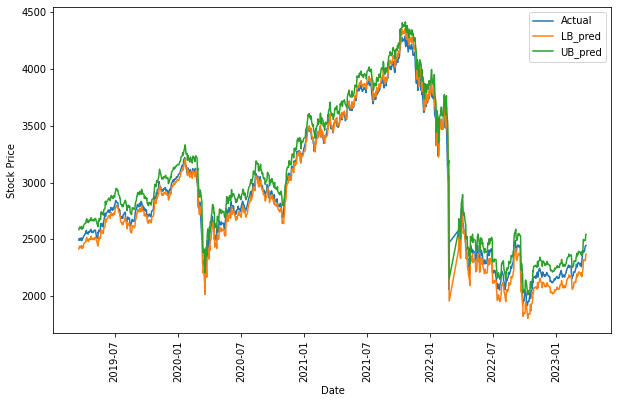

In [27]:
# Plot the actual and predicted stock prices with the upper and lower bounds
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(test['<DATE>'][1:], y_test, label='Actual')


ax.plot(test['<DATE>'][1:], y_pred[:,0], label='LB_pred')
ax.plot(test['<DATE>'][1:], y_pred[:,1], label='UB_pred')

#ax.fill_between(test['<DATE>'], y_pred[:, 0][::forecast_horizon]-y_pred[:, 1][::forecast_horizon], y_pred[:, 0][::forecast_horizon]+y_pred[:, 2][::forecast_horizon], alpha=0.2, label='Bounds')
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Stock Price')
plt.xticks(rotation=90)
plt.show()